# Single Cell RNAseq Data Analysis of Fly Trachea Cells

Authors: Andrew Salem, Nora Rosel

# Introduction

<p style="text-align: justify;">

The Fly Cell Atlas brings together Drosophila researchers interested in single-cell genomics, transcriptomics, and epigenomics, to build comprehensive cell atlases during different developmental stages and disease models. In this project we are going to analyse a specific tissue from the Drosophila in order to determine which cell types are present in it. In our case, the study will focus on the trachea tissue.

We will follow the pipeline suggested in "Preprocessing and clustering 3k PBMCs (legacy workflow)" (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) with some small modifications.

Our aim is to answer the following questions:

<ol>
  <li>How many cell-types are in your dataset?</li>
  <li>Which marker genes characterise each cell-types?</li>
  <li>What cell-types are likely present?</li>
</ol>

The AnnData object will serve as a container for the data and its analysis. Since our dataset was stored in a .gz file, we first decompressed it into a .tsv format before loading it into Scanpy for further processing.

</p>

In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gzip

In [2]:
import igraph

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Step 1: Loading the Dataset and EDA

In [4]:
#Initializing the settings of scanpy as shown in the tutorial 
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [5]:
#loading the data

file_path = "./10_trachea.tsv.gz"

#Read the first line to get the number of columns
first_line = pd.read_csv(file_path, compression='gzip', sep='\t', nrows=1, header=None)
num_cols = first_line.shape[1]

#Use that data to create column names
col_names = ['gene_id']  + [f'cell_{i}' for i in range(1, num_cols)]

In [6]:
#Read file and add headers
df = pd.read_csv(file_path, compression='gzip', sep='\t', header=None, names=col_names)
df.head(5)

gene_id  cell_1  cell_2  cell_3  cell_4  cell_5  cell_6  \
0                128up       0       0       0       1       0       0   
1        14-3-3epsilon       1       0       5       6       2       0   
2           14-3-3zeta       3       0       8       5       2       1   
3                140up       0       0       0       0       0       0   
4  18SrRNA-Psi:CR41602       0       0       0       0       0       0   

   cell_7  cell_8  cell_9  ...  cell_15457  cell_15458  cell_15459  \
0       1       0       0  ...           0           0           0   
1       2       0       0  ...           1           0           0   
2       5       0       2  ...           4           0           1   
3       0       0       0  ...           0           0           0   
4       0       0       0  ...           0           0           0   

   cell_15460  cell_15461  cell_15462  cell_15463  cell_15464  cell_15465  \
0           0           0           0           0           0           0   
1           0           0           0           2           3           7   
2           0           0           1           2           5           0   
3           0           0           0           0           0           0   
4           0           0           0           1           0           0   

   cell_15466  
0           1  
1          11  
2           5  
3           0  
4           0  

[5 rows x 15467 columns]

In [7]:
#Extract gene names
gene_names = df["gene_id"].values

#Prepare expression matrix
expression_matrix = df.iloc[:, 1:].values

#Create cell_ids, same as the column names
cell_ids = [f'cell_{i}' for i in range(1, num_cols)]

In [8]:
#Create AnnData object (genes are supposed to be columns and cells are rows, that's why we transpose)
adata = sc.AnnData(X=expression_matrix.T)

#Add gene names and cell_ids
adata.var_names = pd.Index(gene_names)
adata.obs_names = pd.Index(cell_ids)

adata

AnnData object with n_obs × n_vars = 15466 × 12900

# Step 2: Quality Control (QC)

After having read the data and storing it in the AnnData object that we have named "adata", we need to preprocess the data. We will perform Quality Control (QC) (filtering doublets, ambient RNA and covariates if necessary), thus selecting the cells to continue the analysis workflow.

As explained in the above mentioned Scanpy tutorial, one QC metric used will be the number of unique genes that can be detected per cell, given that empty droplets will have very few while doublets will have a high unique gene count. Also, the reads that are mapped to mitochondrial genome will be a quality indicator, given that low quality cells (dying or stressed cells) have an excessively high mitochondrial gene count.

normalizing counts per cell
    finished (0:00:02)


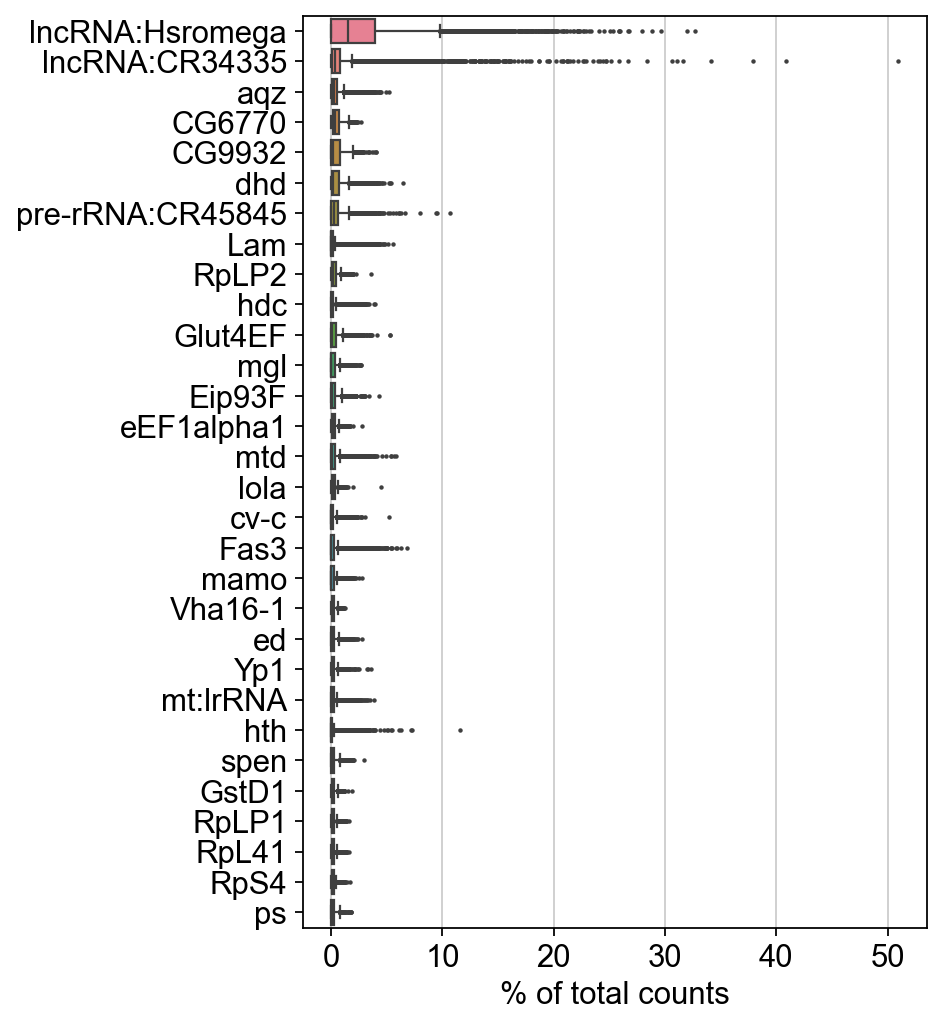

In [9]:
sc.pl.highest_expr_genes(adata)

#Very common to have non coding RNA, stabilizing role

In the subsequent section, we had too many problems creating and applying a mitochondrial gene mask for quality control. We therefore decided to go with a much safer approach where we explored the genes one by one by looking at common prefixes (mt:, mt-, etc.) associated with mitochondrial genes on FlyBase.

In [10]:
#Check for mitochondrial genes
mt_patterns = ["mt:", "mt-", "mtDNA", "mito", "mt"]
mt_gene_counts = {}
all_mt_genes = []
problem_genes = []

for pattern in mt_patterns:
    matches = [name for name in adata.var_names if isinstance(name, str) and name.startswith(pattern)]
    mt_gene_counts[pattern] = len(matches)
    all_mt_genes.extend(matches)

#Print summary
for pattern, count in mt_gene_counts.items():
    print(f"Found {count} genes with prefix '{pattern}'")

print(f"Total mitochondrial genes found: {len(all_mt_genes)}")
if all_mt_genes:
    print("Examples:", all_mt_genes[:5])

#Check for problematic gene names
problem_genes = [name for name in adata.var_names if not isinstance(name, str)]
if problem_genes:
    print(f"Found {len(problem_genes)} problematic gene names")
    print("Examples:", problem_genes[:5])

#Why is a nan present in the dataset?

Found 22 genes with prefix 'mt:'
Found 0 genes with prefix 'mt-'
Found 1 genes with prefix 'mtDNA'
Found 0 genes with prefix 'mito'
Found 46 genes with prefix 'mt'
Total mitochondrial genes found: 69
Examples: ['mt:ATPase6', 'mt:ATPase8', 'mt:CoI', 'mt:CoII', 'mt:CoIII']
Found 1 problematic gene names
Examples: [nan]


In [11]:
#Exclude non mitochondrial genes that have "mt" prefixes found on Flybase
genes_to_exclude = ['mtd', 'mtg', 'mtgo', 'mth', 'mthl1', 'mthl10', 'mthl11', 'mthl13',
                    'mthl14', 'mthl15', 'mthl2', 'mthl3', 'mthl4', 'mthl5', 'mthl8',
                    'mthl9', 'mtm', 'mtrm', 'mts', 'mtt']

#Remove those genes from the mitochondrial genes list
filtered_mt_genes = [gene for gene in all_mt_genes if gene not in genes_to_exclude]

#Use the final mitochondrial genes list to create a mask
adata.var["mt"] = adata.var_names.isin(filtered_mt_genes)
print(f"Total mitochondrial genes identified: {adata.var['mt'].sum()}")

Total mitochondrial genes identified: 26


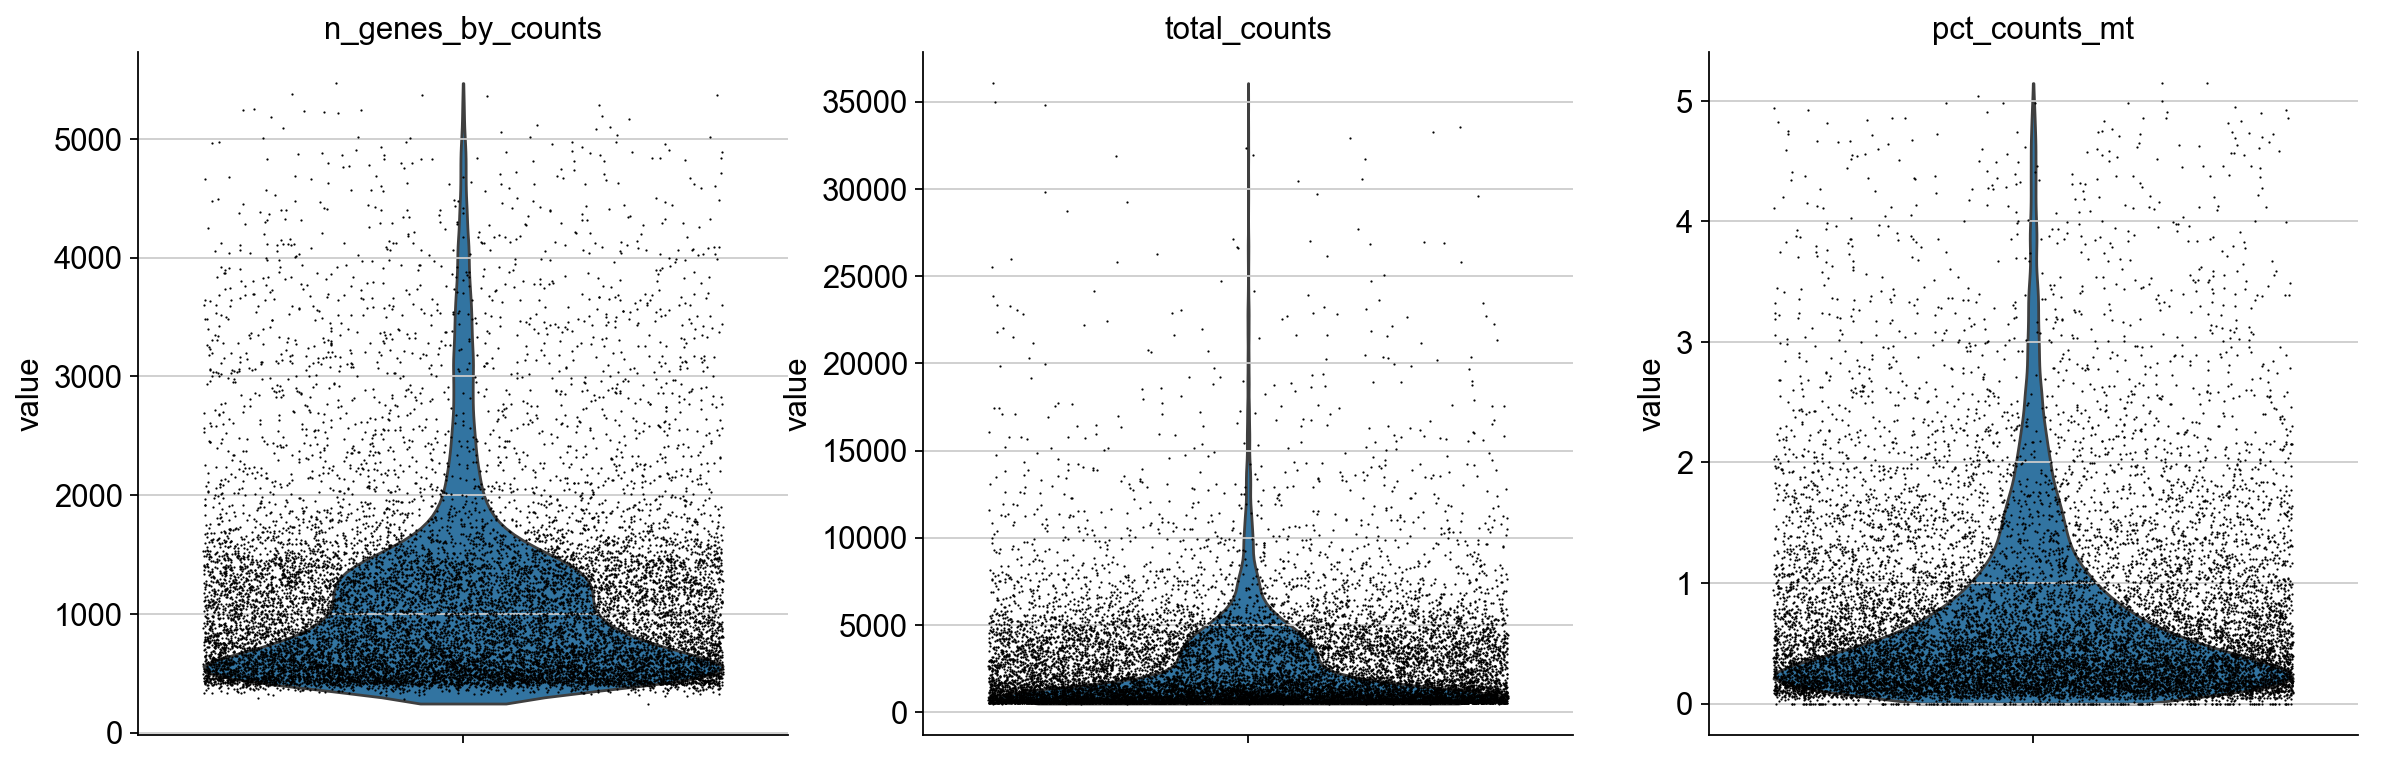

In [12]:
#Compute and plot quality metrics (unique genes per cell, total number of UMI, percentage of mitochondrial reads per cell)
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

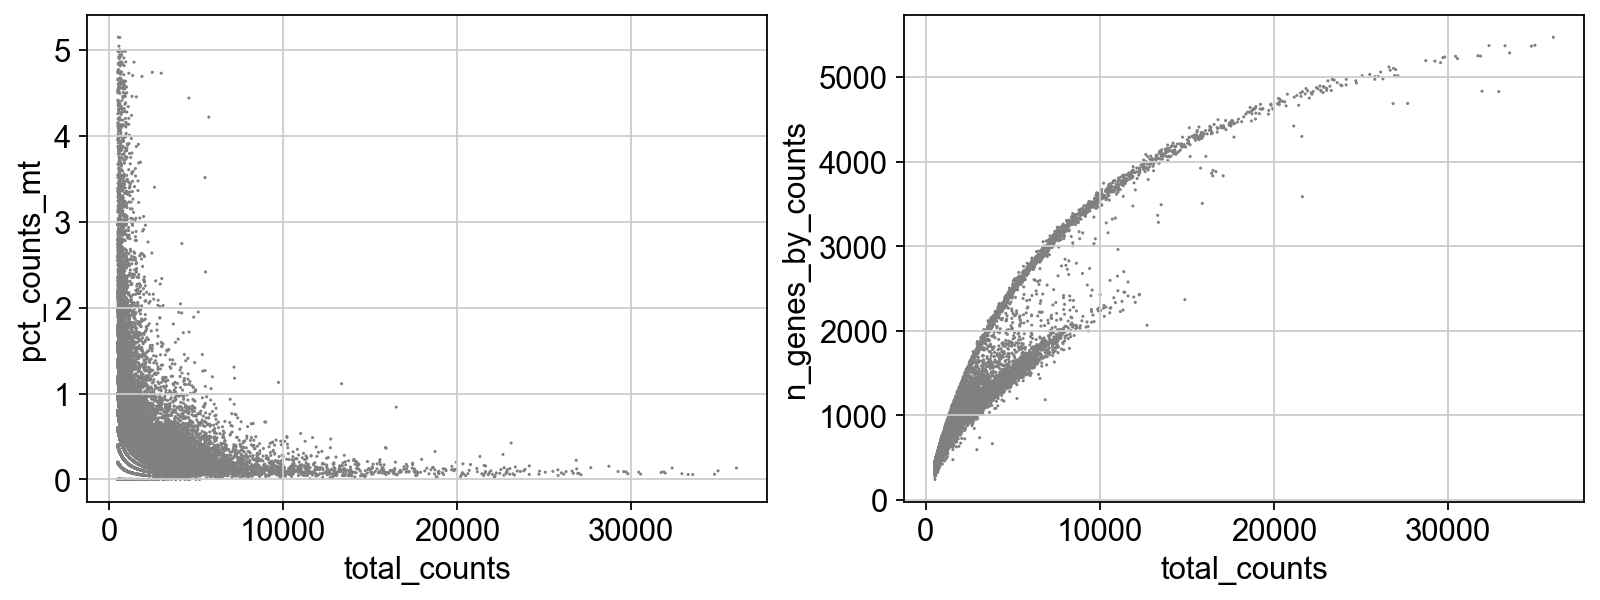

In [13]:
#Plot features against one another
fig, axs = plt.subplots(1,2, figsize=(12,4))
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt",ax=axs[0], show=False) #Mitochondrial genes
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=axs[1], show=False) #Unique genes

# Filtering cells out

We tried to filter as least as possible at first, planning to check all QC metrics if we saw something weird in our final UMAP clusters. Since there are no clear outliers and the values are somewhat continuous, we considered not filtering out any of the cells. To be sure, we compared the results obtained when filtering the cells and when not filtering them. We found that there was no change in the clustering and identification of cell-types; therefore, we decided not to filter at all.

In [14]:
#filtering
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)

# Step 3: Normalization of the data


After the Quality Control and the selection of cells, our next step was to normalize the data. Briefly, the method we used normalises the expression for each cell by the total expression, multiplied by a scale factor (we used the default value of 10,000), and then the result is log-transformed.


In [15]:
#Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)

#logarithmize data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


# Step 4: Identification of highly variable genes in all the dataset

After normalization, we calculated the features that have a high variation cell-to-cell. By selecting highly variable genes, we prioritize genes that are most informative for clustering and downstream analysis.

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


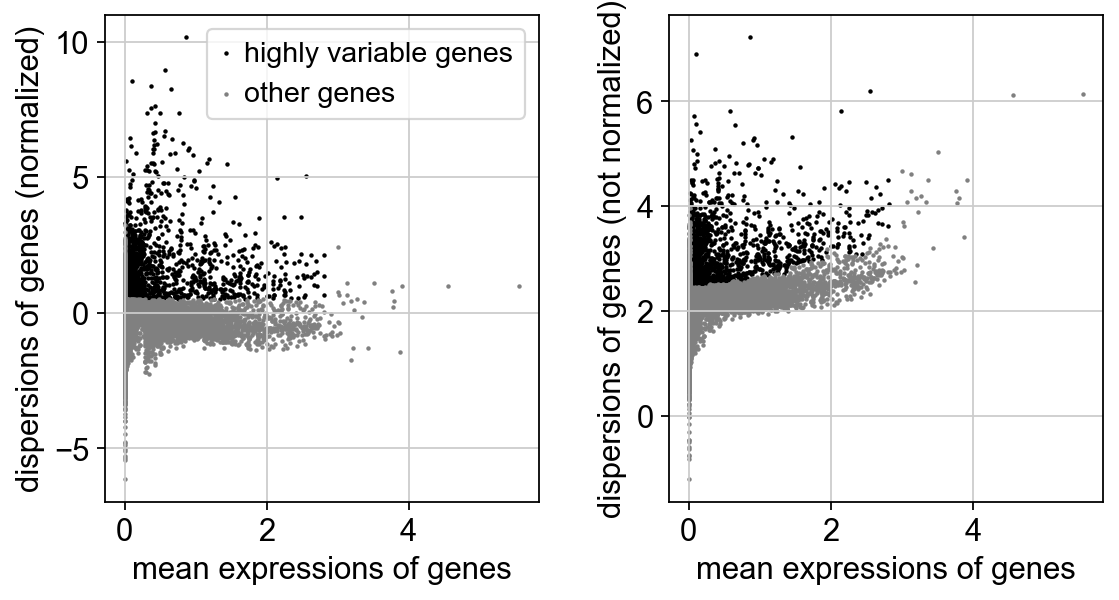

In [16]:
#Extract highly variable genes and show their numbers
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata)

In [17]:
#Filter out highly variable genes
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]

In [18]:
#Regress out confounders
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']


C:\Users\norar\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:709: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:01)



# Step 5: Dimension reduction (PCA)

Next, we have to reduce the dimensionality of our data by running Principal Component Analysis (PCA), which reveals the main axes of variation and denoises the data.

First, we scale the data such that mean expression equals to 0 and variance to 1, so that the highly expressed genes do not dominate in the subsequent analysis. 

In [19]:
#Scale from 0 to 1, clipping values whose standard deviation exceeds 10 to allow for dimensionality reduction
sc.pp.scale(adata, max_value=10)

In [20]:
sc.tl.pca(adata,svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:02)


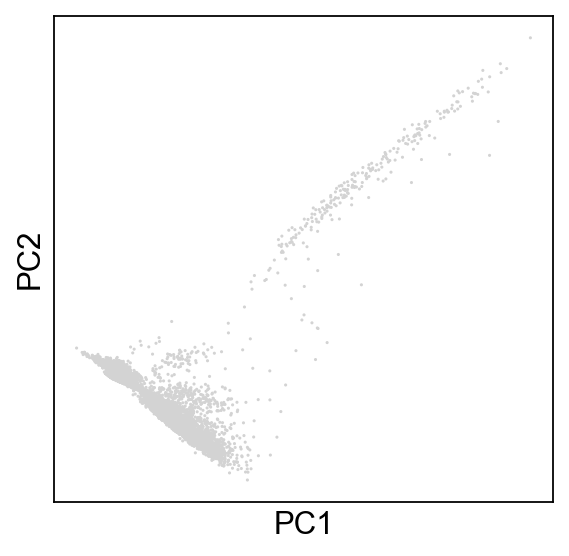

C:\Users\norar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


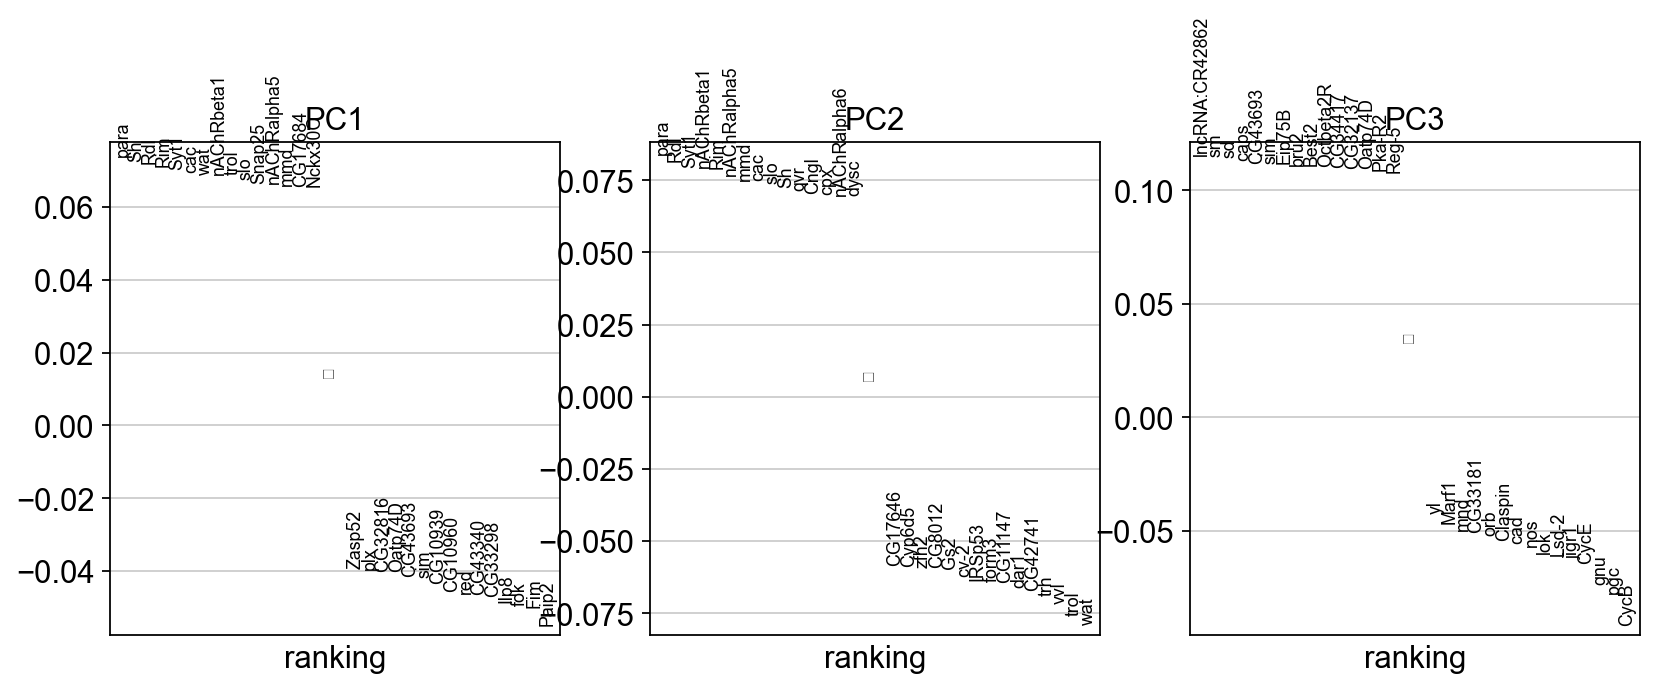

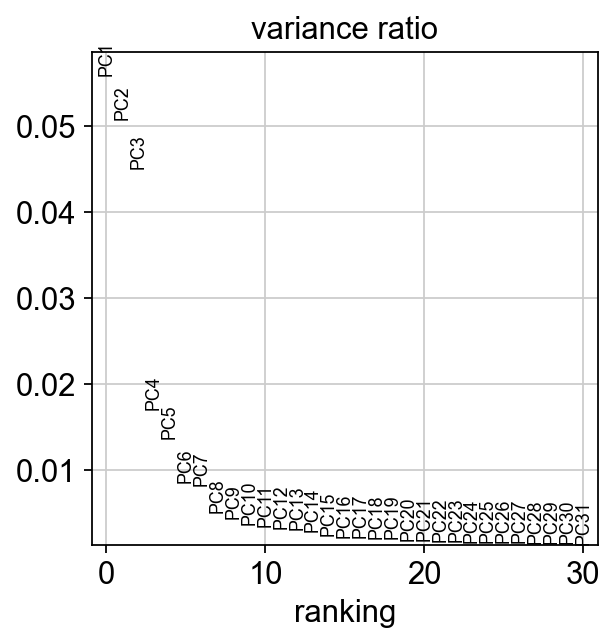

In [21]:
sc.pl.pca_overview(adata)

We will explore different ways to guess the number of Principal Components to retain. First, looking at the variance ratio plot, we see an elbow shape with an inflection point at around PC7. We will also compute how many PCs are required to explain 95% of the variance and compare this number to our assumption.

In [22]:
#Get cumulative explained variance
explained_var = adata.uns['pca']['variance_ratio']
explained_var

array([0.05578268, 0.050705  , 0.04501423, 0.01709234, 0.01371286,
       0.0085981 , 0.00827623, 0.00515894, 0.00440151, 0.00367967,
       0.00347585, 0.00326564, 0.00310845, 0.00286548, 0.00242353,
       0.00227478, 0.00222527, 0.0020837 , 0.00205676, 0.0019315 ,
       0.00189209, 0.00180053, 0.00173924, 0.00169509, 0.00168759,
       0.00163268, 0.00160887, 0.00156966, 0.00152513, 0.00150529,
       0.00146831, 0.00145742, 0.00142577, 0.00139559, 0.00137778,
       0.00135264, 0.00133558, 0.00131949, 0.00131556, 0.00130859,
       0.00129182, 0.00126974, 0.00124495, 0.0012378 , 0.001231  ,
       0.00122221, 0.00121487, 0.00121025, 0.00120202, 0.00119947],
      dtype=float32)

# Step 6: Choosing the Right Number of Principal Components

To avoid having a very noisy dataset, we cluster the cells based on their PCA score. We should only keep the top principal components to represent the dataset, but it seems that our PCs each explain too little of the variance (max 0.05%); thus, we will retain 50 of them, as this number should be adequate.

In [23]:
#Compute neighborhood graph, using Euclidean distance in PCA space
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:28)


# Step 7: Clustering the Cells
After having performed PCA and decided on the dimensions that are to be kept, we have to cluster the cells. As previously seen, PCA is not a good technique to visualise the clusters, and that is why we need another visualisation method to explore the data. We decided to use UMAP as its representation was the most helpful to distinguish between clusters.

In [24]:
#To not display the enormously long warnings
%%capture --no-display
#Cluster the cells using the Leiden algorithm
sc.tl.leiden(adata, resolution=0.1, random_state=0, flavor="igraph", n_iterations=2, directed=False)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:53)


In [25]:
#Perform UMAP initialization
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)


# Step 8: Visualizing the Clusters (UMAP)

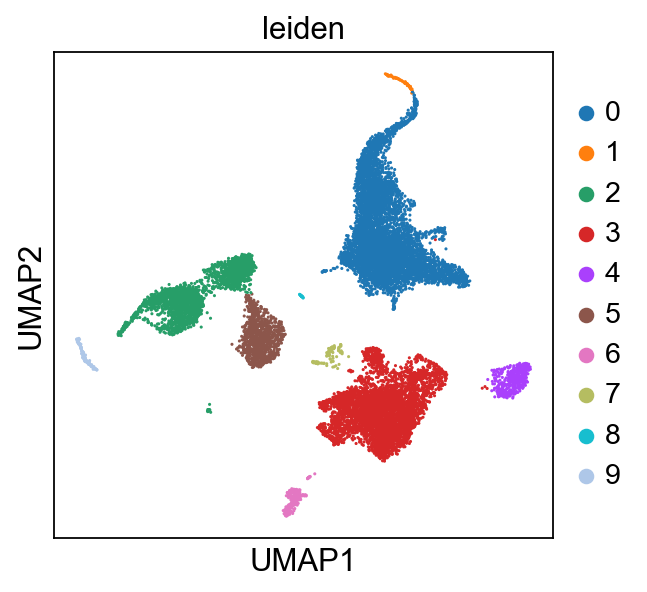

In [26]:
#Visualize UMAP with Leiden clusters and marker genes
sc.pl.umap(adata, color=["leiden"])

# Step 9: Differential Expression Analysis

After having clustered and visualized the cells, we need to find markers that will help us identify what cell type each cluster represents. This is the most challenging task of all the analysis done. Firstly, we find all markers per cluster using the default test "wilcoxon".

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:38)


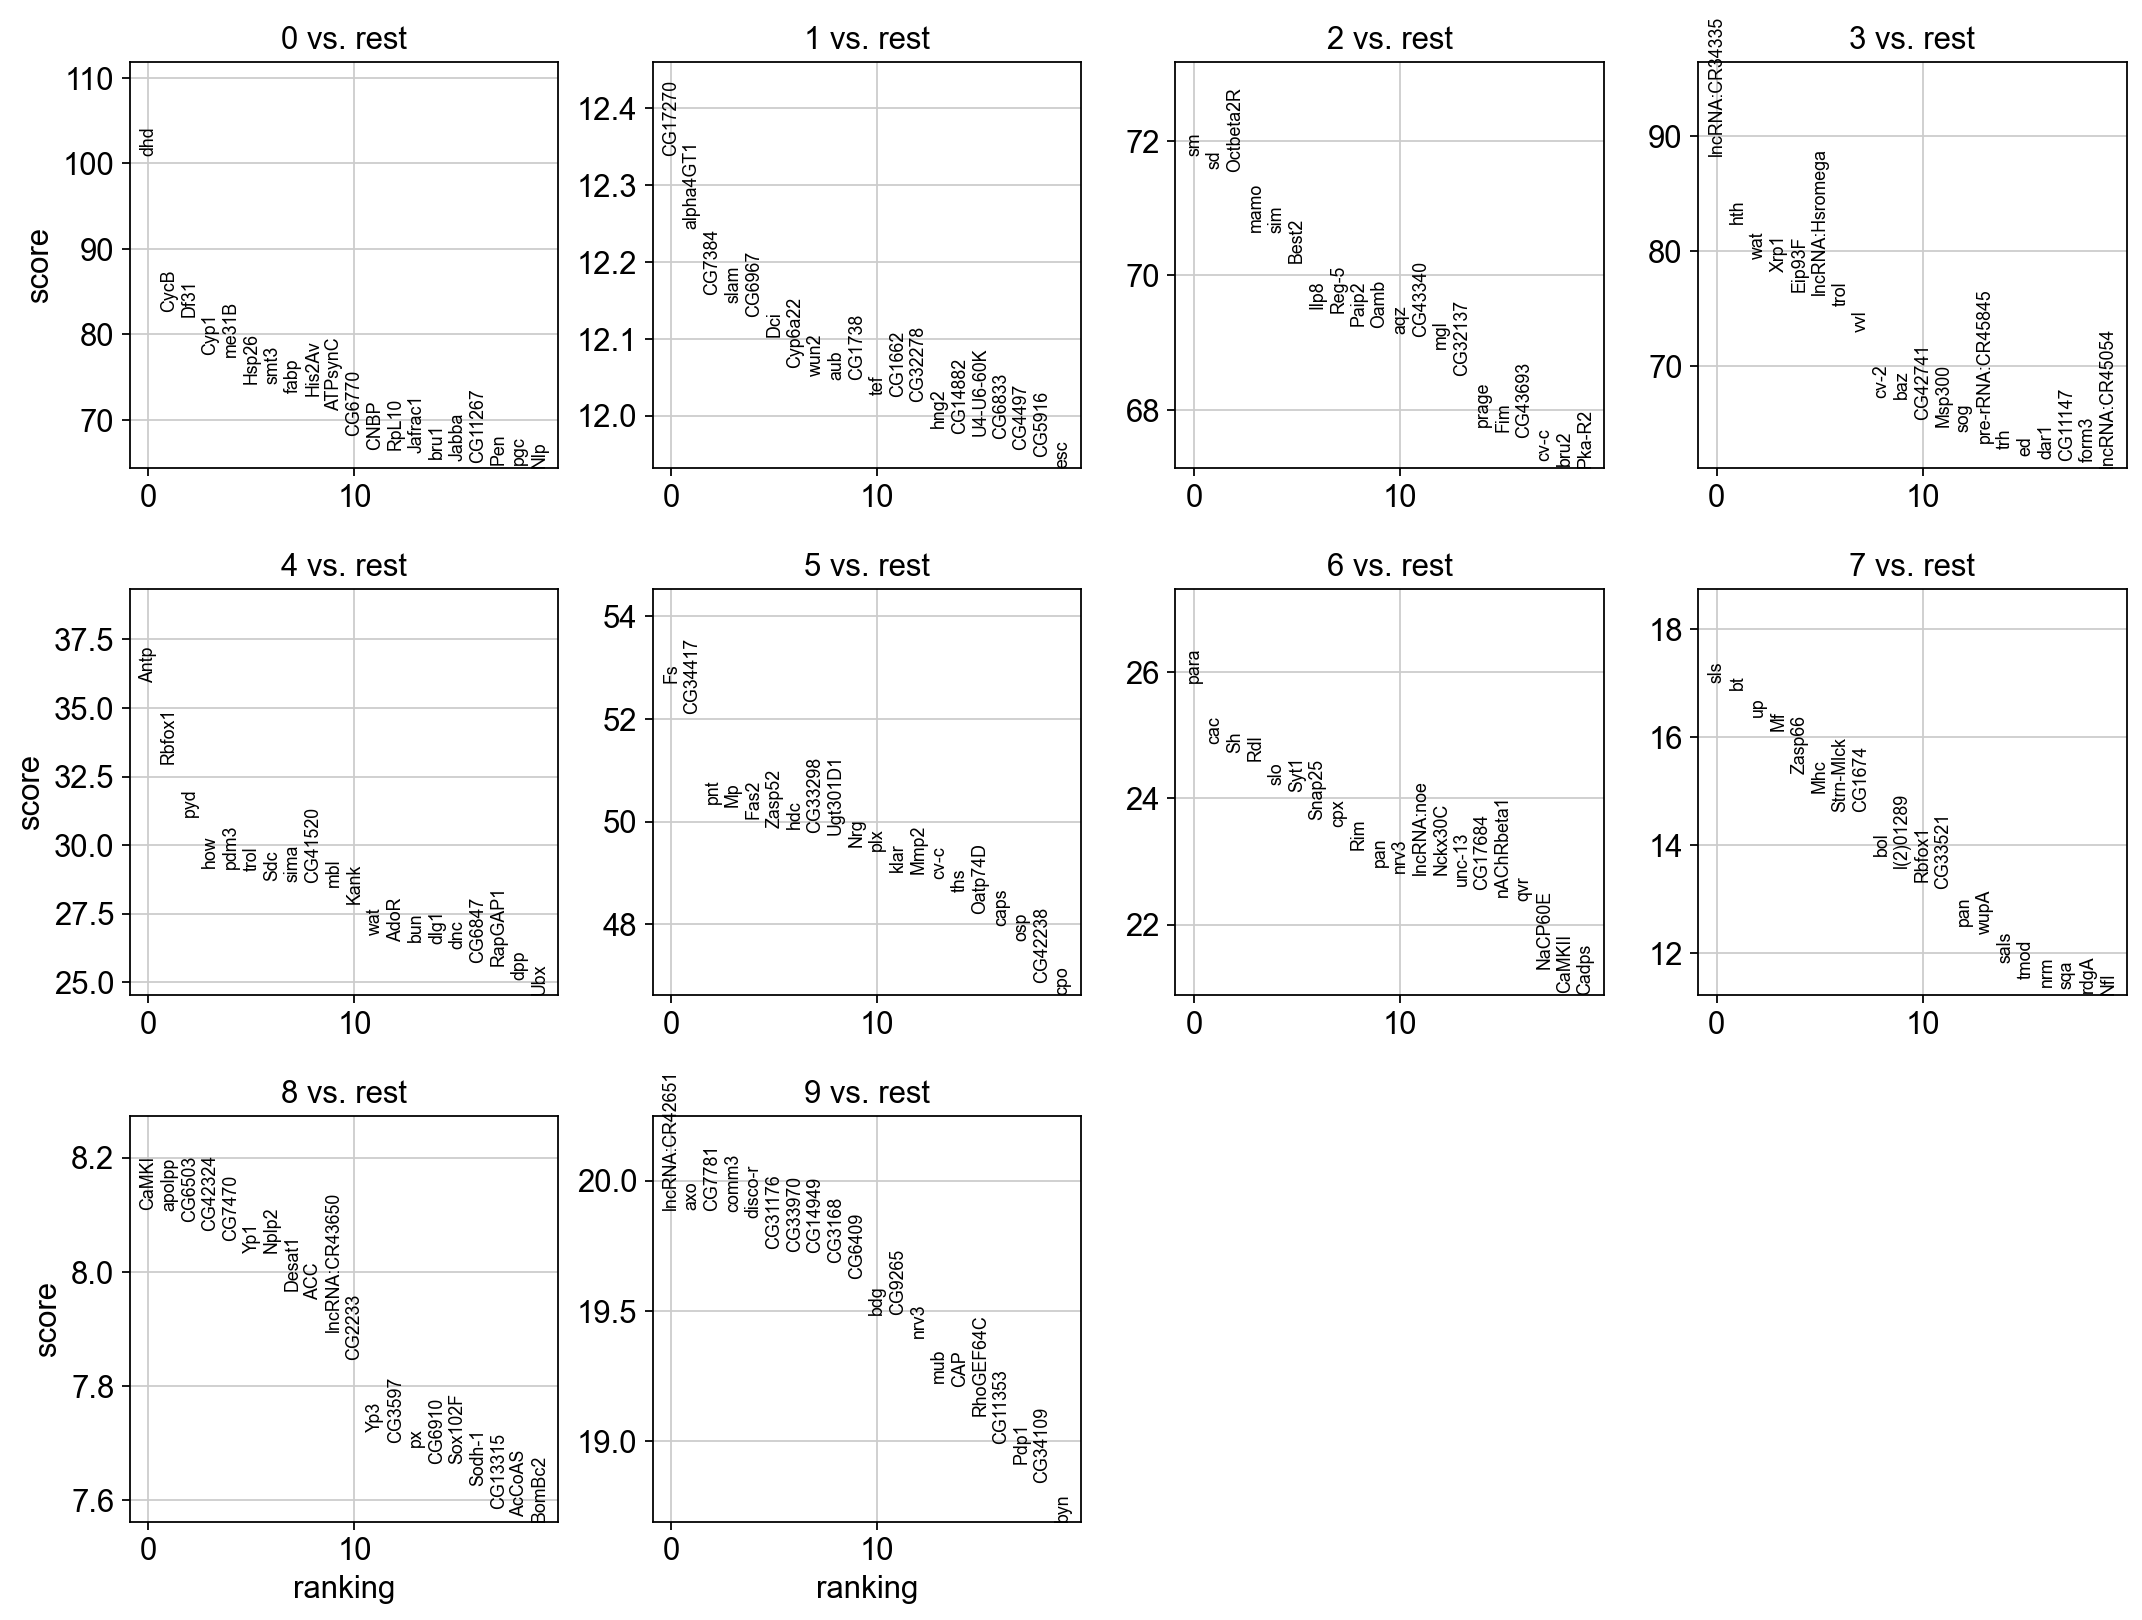

0          1          2                3       4        5       6  \
0    dhd    CG17270         sm   lncRNA:CR34335    Antp       Fs    para   
1   CycB  alpha4GT1         sd              hth  Rbfox1  CG34417     cac   
2   Df31     CG7384  Octbeta2R              wat     pyd      pnt      Sh   
3   Cyp1       slam       mamo             Xrp1     how       Mp     Rdl   
4  me31B     CG6967        sim           Eip93F    pdm3     Fas2     slo   
5  Hsp26        Dci      Best2  lncRNA:Hsromega    trol   Zasp52    Syt1   
6   smt3    Cyp6a22       Ilp8             trol     Sdc      hdc  Snap25   

           7        8               9  
0        sls    CaMKI  lncRNA:CR42651  
1         bt   apolpp             axo  
2         up   CG6503          CG7781  
3         Mf  CG42324           comm3  
4     Zasp66   CG7470         disco-r  
5        Mhc      Yp1         CG31176  
6  Strn-Mlck    Nplp2         CG33970

In [27]:
#Find marker genes for each cluster using Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

top_genes = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

#Extract top 7 genes for each cluster
top_genes.head(7)

For the selection of the marker genes, we select those whose expression is very different in one particular cell-type. This task is sometimes difficult, as for some clusters more than one marker gene belonging to more than one cell-type could be identified. To address this, we implemented a selection approach that identifies genes appearing uniquely within a given cluster’s top-ranked markers. Specifically, we extract the top genes per cluster and filter those that appear in multiple clusters, ensuring we prioritize markers that distinctly characterize a single cell type. If no unique marker is found, we default to the most highly ranked gene. This method enhances specificity in cell-type annotation while minimizing ambiguous assignments.

In [28]:
#Select the top marker gene per cluster
def select_specific_top_gene(df, n=10, max_occurrences=1):
    
    selected_genes = {}
    
    #Maps gene names to the clusters where they appear within the top n rows
    gene_clusters = {}
    for col in df.columns:
        #Get the top n genes for this cluster
        top_genes = df[col].head(n)
        for gene in top_genes:
            gene_clusters.setdefault(gene, set()).add(col)
    
    #Choose the first gene in the top n that meets the uniqueness criteria
    for col in df.columns:
        top_genes = df[col].head(n)
        for gene in top_genes:
            #Count how many clusters (among top n) contain this gene
            occurrence = len(gene_clusters[gene])
            if occurrence <= max_occurrences:
                selected_genes[col] = gene
                break
        #If no gene meets the criteria, fallback to the very top gene
        if col not in selected_genes:
            selected_genes[col] = top_genes.iloc[0]
    
    return selected_genes

In [29]:
top_candidates = select_specific_top_gene(top_genes,100,0)
top_candidates

{'0': 'dhd',
 '1': 'CG17270',
 '2': 'sm',
 '3': 'lncRNA:CR34335',
 '4': 'Antp',
 '5': 'Fs',
 '6': 'para',
 '7': 'sls',
 '8': 'CaMKI',
 '9': 'lncRNA:CR42651'}

After identifying the gene markers, we use the Fly Cell Atlas (more specifically the ASAP website) to identify the cell-type that each marker shows. From ASAP we know that there are 10 cell types in our tissue (plus the unannotated one), and in our analysis we have also identified 10 clusters. Following a manual search of the marker genes on the ASAP website, we identified the following cell types for each cluster:

Cluster 0: btl-GAL4 positive female cell, cluster 1, likely to be ovary cell; btl-GAL4 positive female cell, cluster 2, likely to be ovary cell; btl-GAL4 positive female cell, cluster 3, likely to be ovary cell.

Cluster 1: btl-GAL4 positive female cell, cluster 1, likely to be ovary cell; btl-GAL4 positive female cell, cluster 2, likely to be ovary cell.

CLuster 2: btl-GAL4 positive female cell, likely to be ovary cell, sim+; btl-GAL4 positive female cell, likely to be ovary cell, sim+, H15+.

Cluster 3: adult tracheal cell.

Cluster 4: adult tracheal cell; unannotated.

Cluster 5: btl-GAL4 positive female cell, likely to be ovary cell, sim+, H15+.

Cluster 6: adult neuron.

Cluster 7: muscle cell.

Cluster 8: unannotated.

Cluster 9: adult tracheal cell; unannotated.

Our clusters do not fully match those displayed in ASAP; to ensure our classification was robust, we checked not only the top-ranking marker gene per cluster but also the top three highest-ranking genes. We also examined whether the highest-ranking gene appeared in the top 25 and top 100 genes per cluster, and the results remained the same. We tried to justify the reason for the differences found:

- In our analysis, Cluster 0 corresponds to multiple clusters from ASAP (clusters 1, 2 and 3 for the btl-GAL4 positive female cell). This makes sense, as one cell type should be present in one single cluster. We could think that in the ASAP website, the different clusters for the same cell type represent different states of said cell. We also justify the presence of these ovary cells by seeing that the fly trachea is present in the whole body of the fly.

 - We identified adult tracheal cells primarily in Cluster 3 but also in Clusters 4 and 9, which suggests some degree of heterogeneity within this cell type (which makes sense for it to be present across different clusters, since our tissue is the tracheal tissue).
 
- We did not detect adult fat body or eye photoreceptor cells as distinct clusters, unlike ASAP (where the clusters for these two cell types are very small). This could be due to overlapping marker genes, particularly with btl-GAL4 positive female cells, leading to their inclusion within that category.

# Step 10:  Annotate the UMAP Cluster with Cell Types

After identifying the cell-types we plot the results (marker gene per cluster). Our violin plots confirm the faithful results of our analysis, since we see that each marker gene is distinctly expressed within its respective cluster, demonstrating clear differentiation.

In [30]:
def plot_cluster_marker(adata, top_candidates, cluster, palette=None):

    #Ensure cluster is a string, as top_candidates keys are strings
    cluster_str = str(cluster)
    
    #Retrieve the top gene for the given cluster
    top_gene = top_candidates[cluster_str]
    
    #Create a figure with GridSpec: top row (full width) and bottom row (two columns)
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    #Top row: UMAP plot for the specified cluster only (other cells in background)
    ax1 = fig.add_subplot(gs[0, :])
    if palette is not None:
        sc.pl.umap(adata, color='leiden', groups=[cluster_str], ax=ax1, show=False, palette=palette)
    else:
        sc.pl.umap(adata, color='leiden', groups=[cluster_str], ax=ax1, show=False)
    ax1.set_title(f'UMAP: Highlighting Cluster {cluster_str} cells')
    
    #Bottom row, left: UMAP plot showing top_gene expression (colored by gene expression)
    ax2 = fig.add_subplot(gs[1, 0])
    sc.pl.umap(adata, color=top_gene, ax=ax2, show=False)
    ax2.set_title(f'UMAP: {top_gene} Expression')
    
    #Bottom row, right: Violin plot showing gene expression across all clusters
    ax3 = fig.add_subplot(gs[1, 1])
    sc.pl.violin(adata, keys=top_gene, groupby='leiden', ax=ax3, show=False)
    ax3.set_title(f'Violin Plot for {top_gene}')
    
    fig.suptitle(f'Cluster {cluster_str} Marker: {top_gene}', fontsize=16)
    plt.tight_layout()
    
    #Return the figure for further use or saving
    return fig

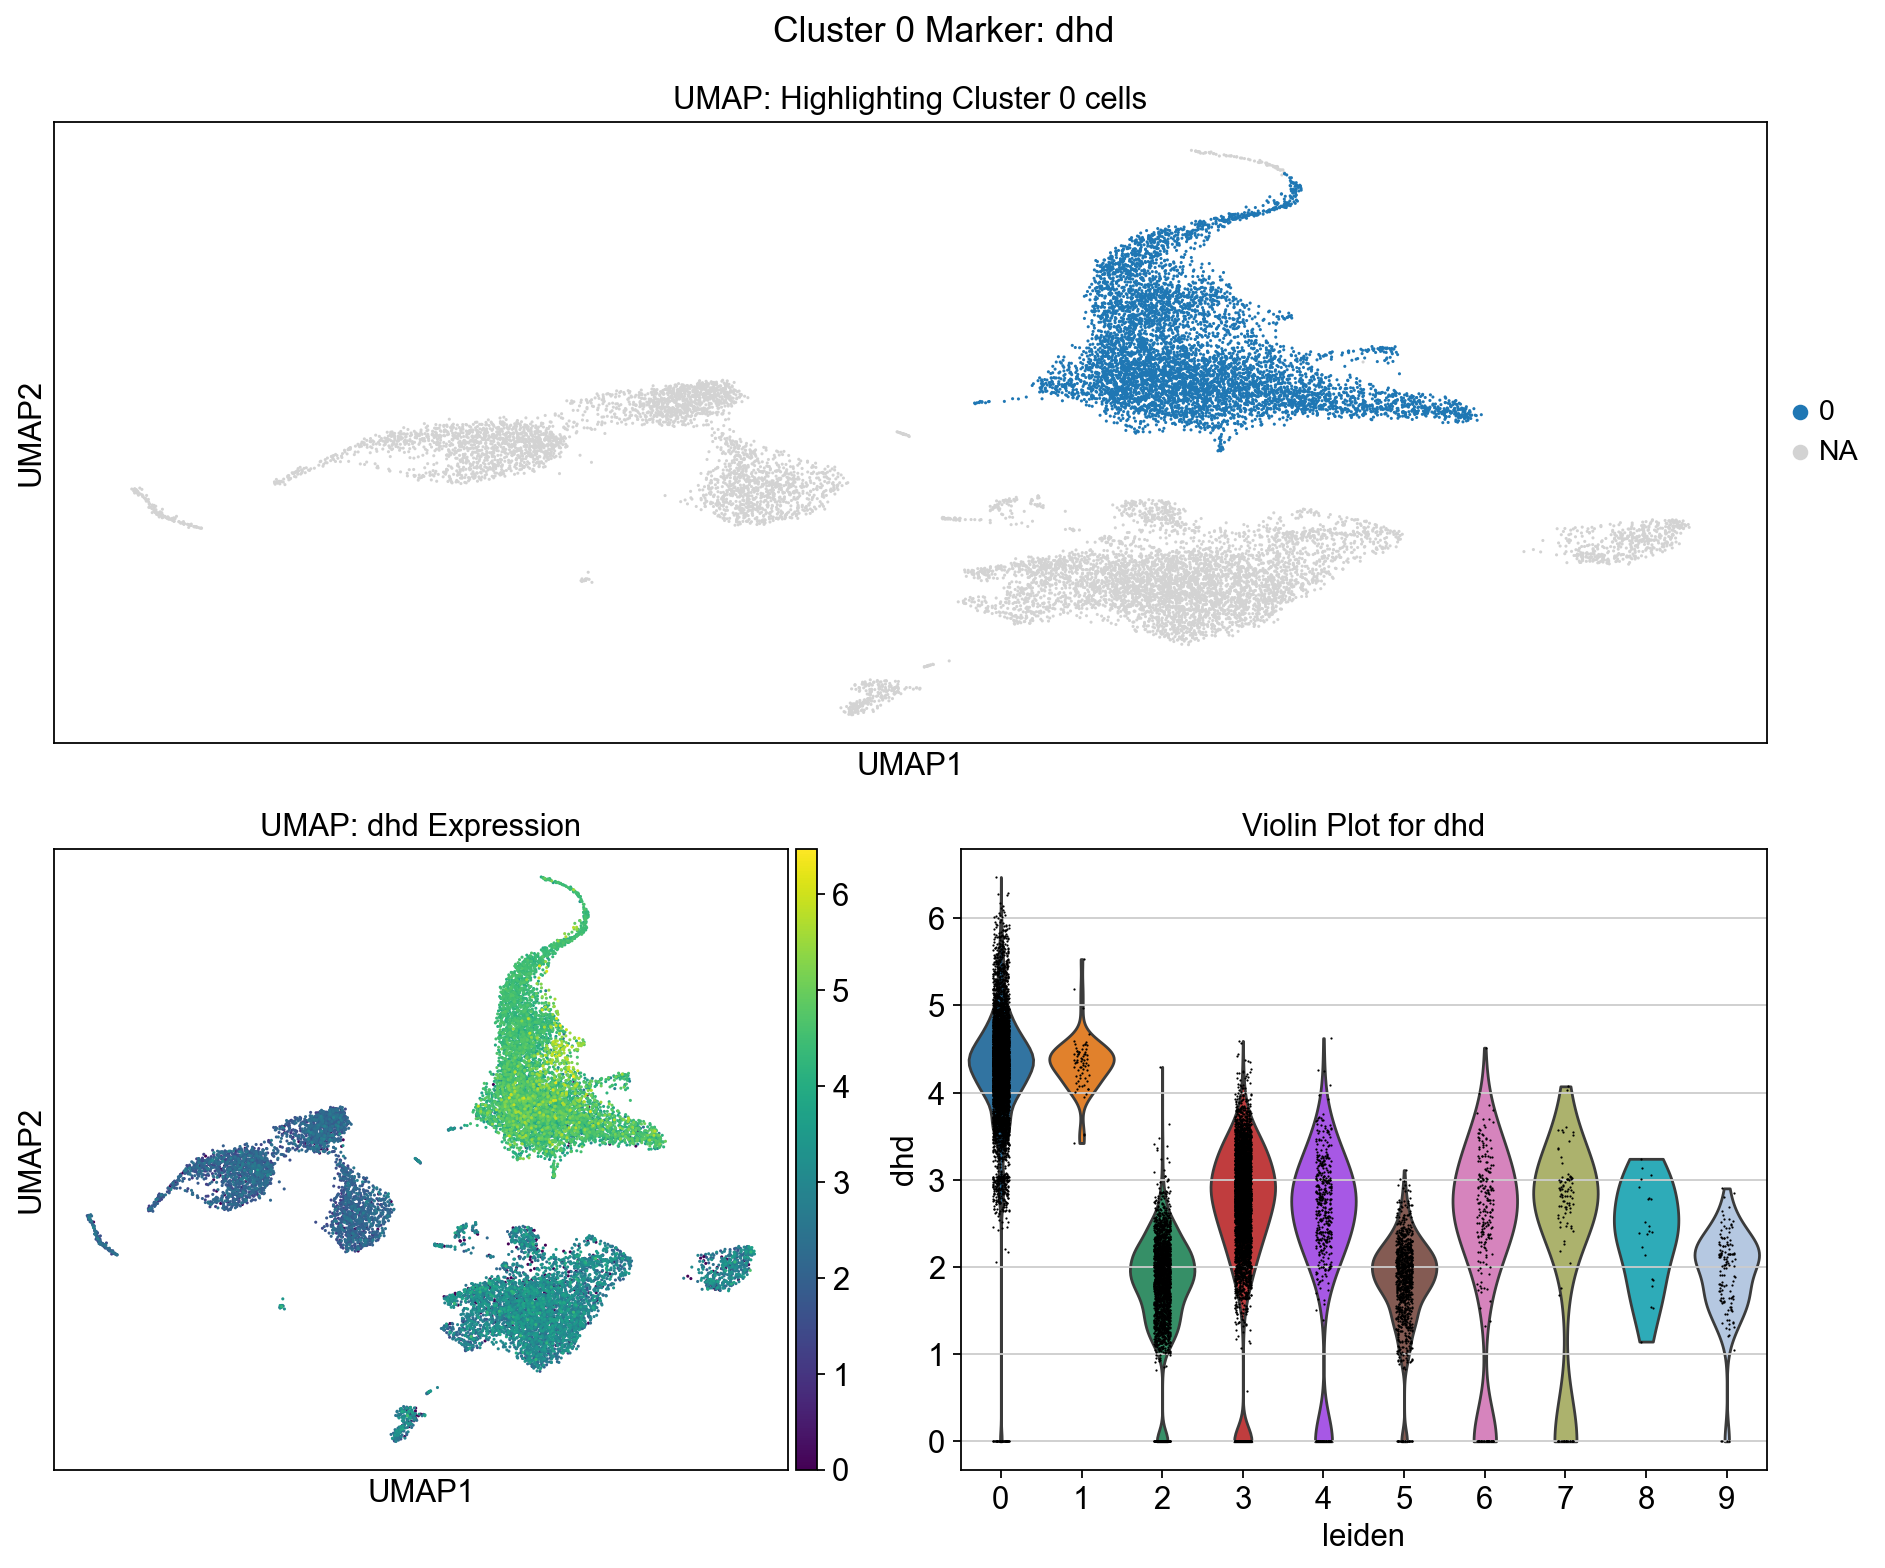

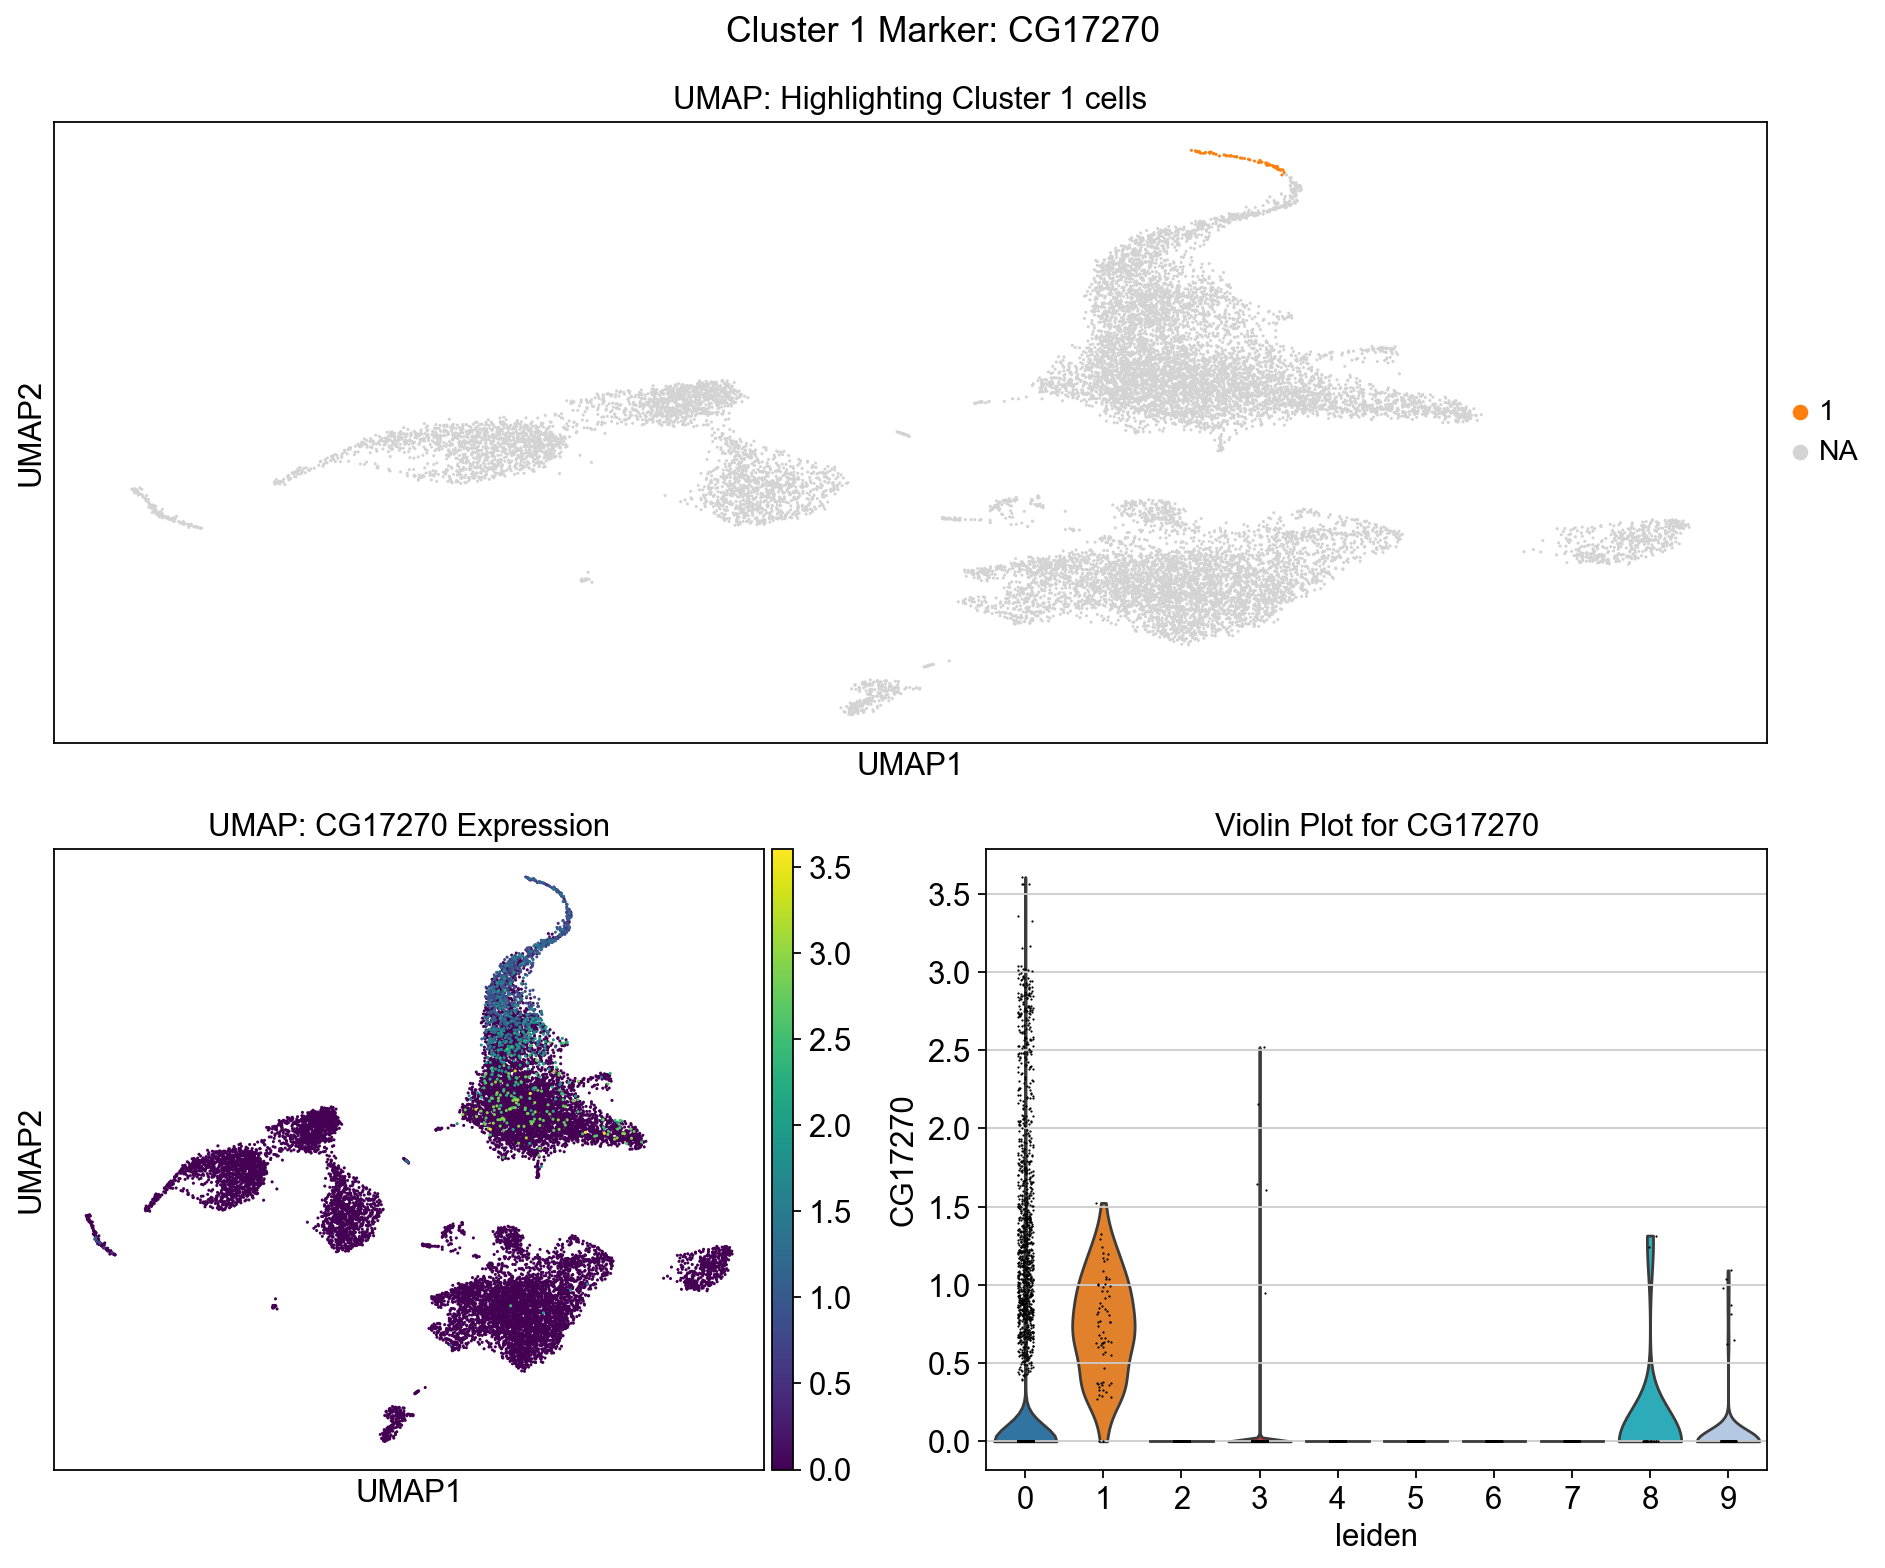

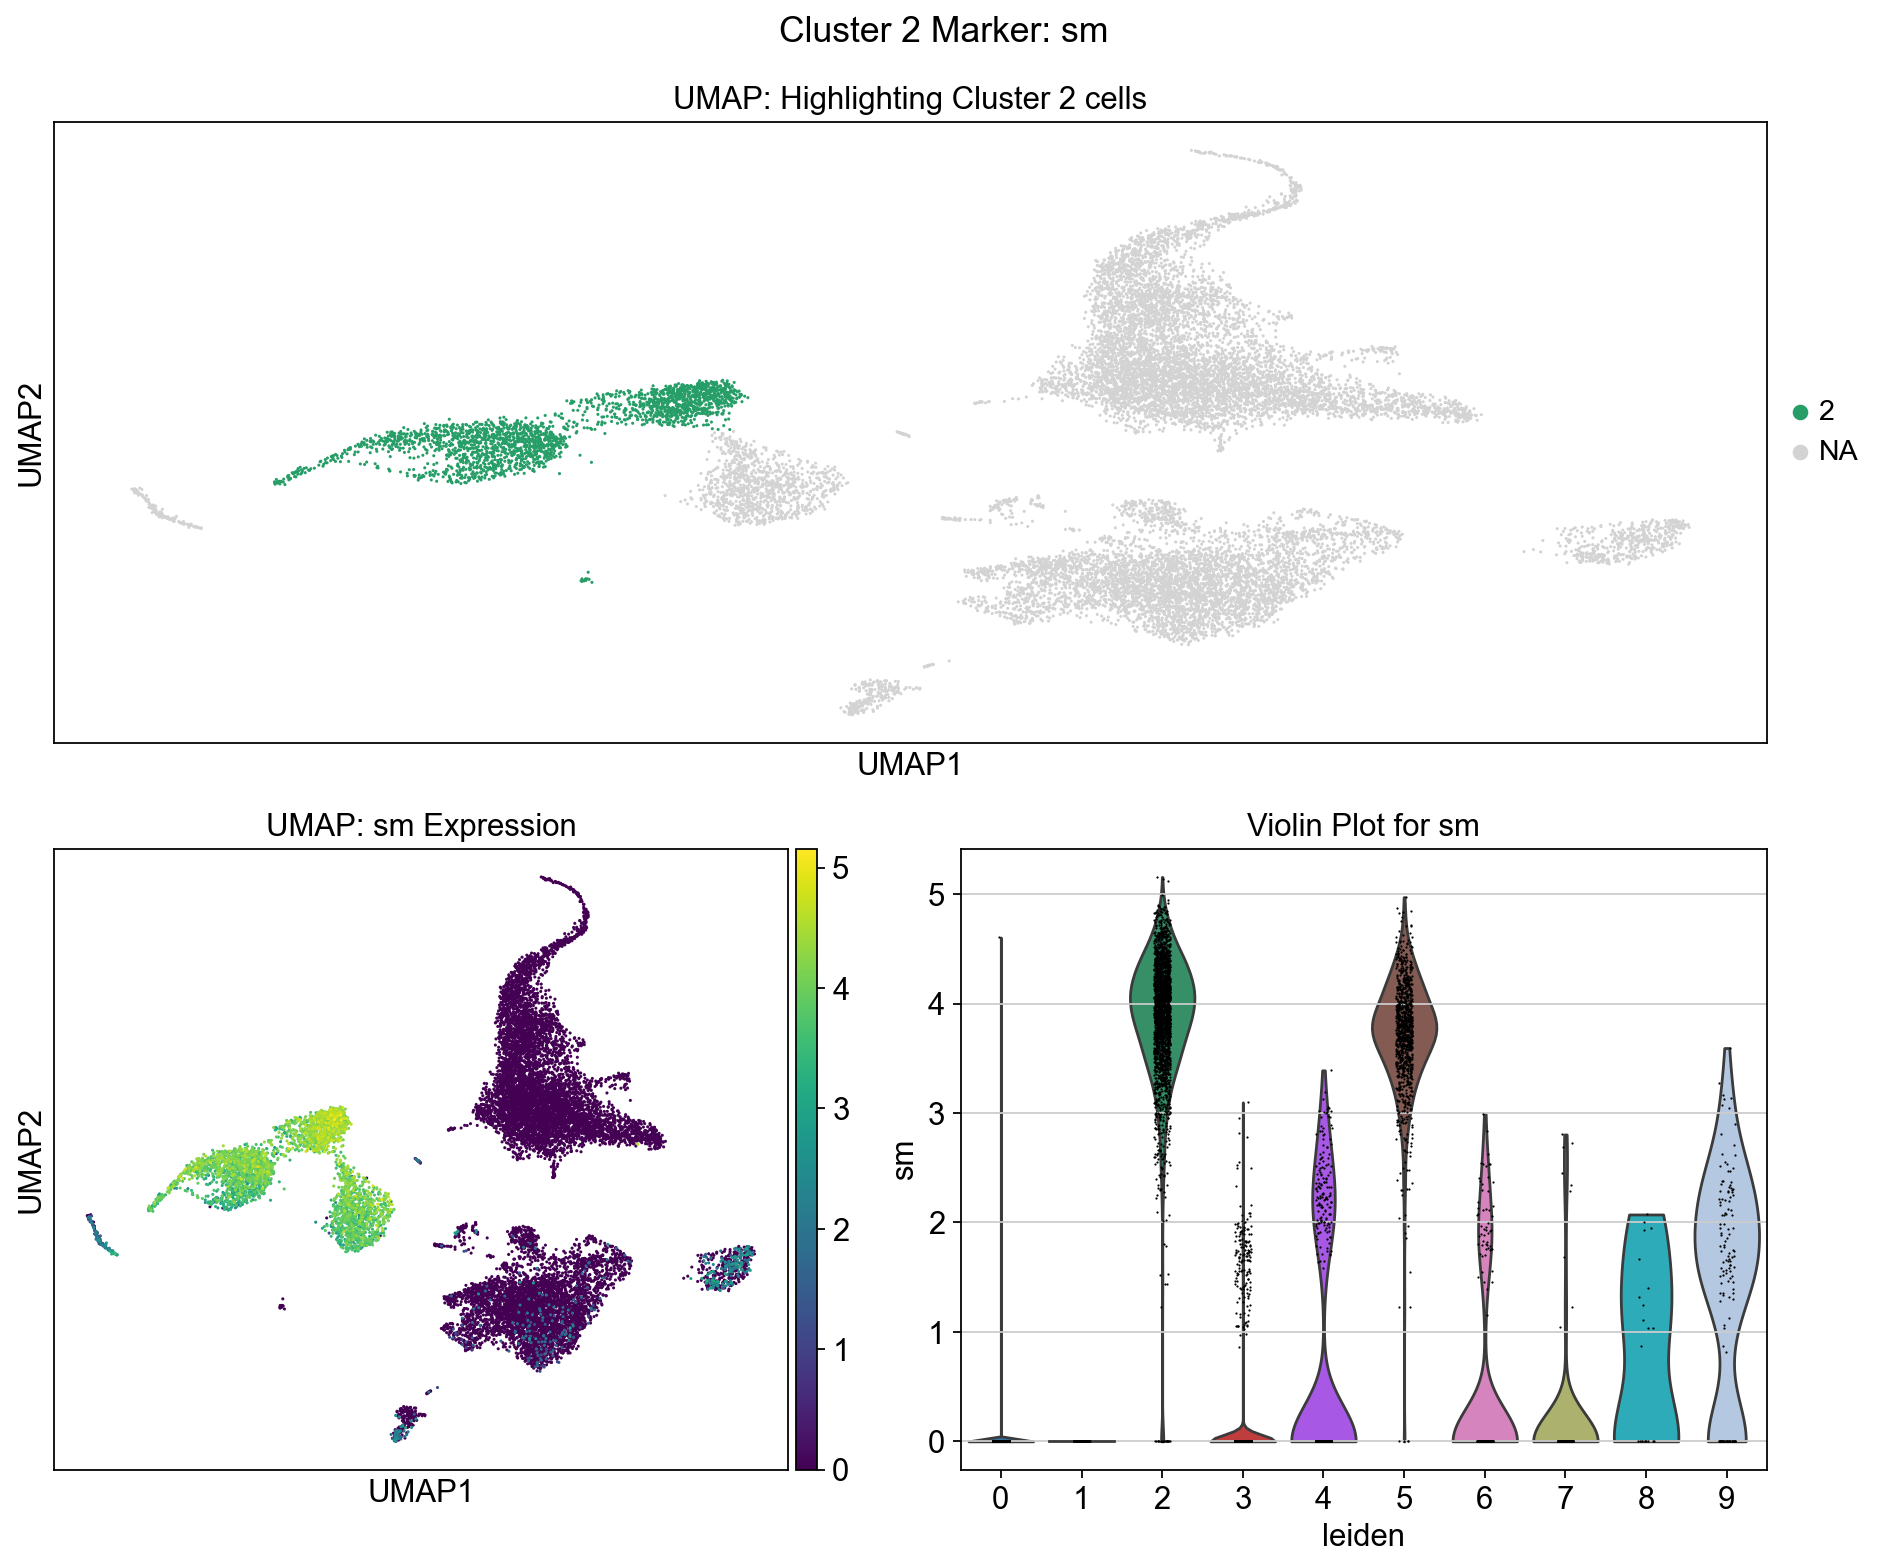

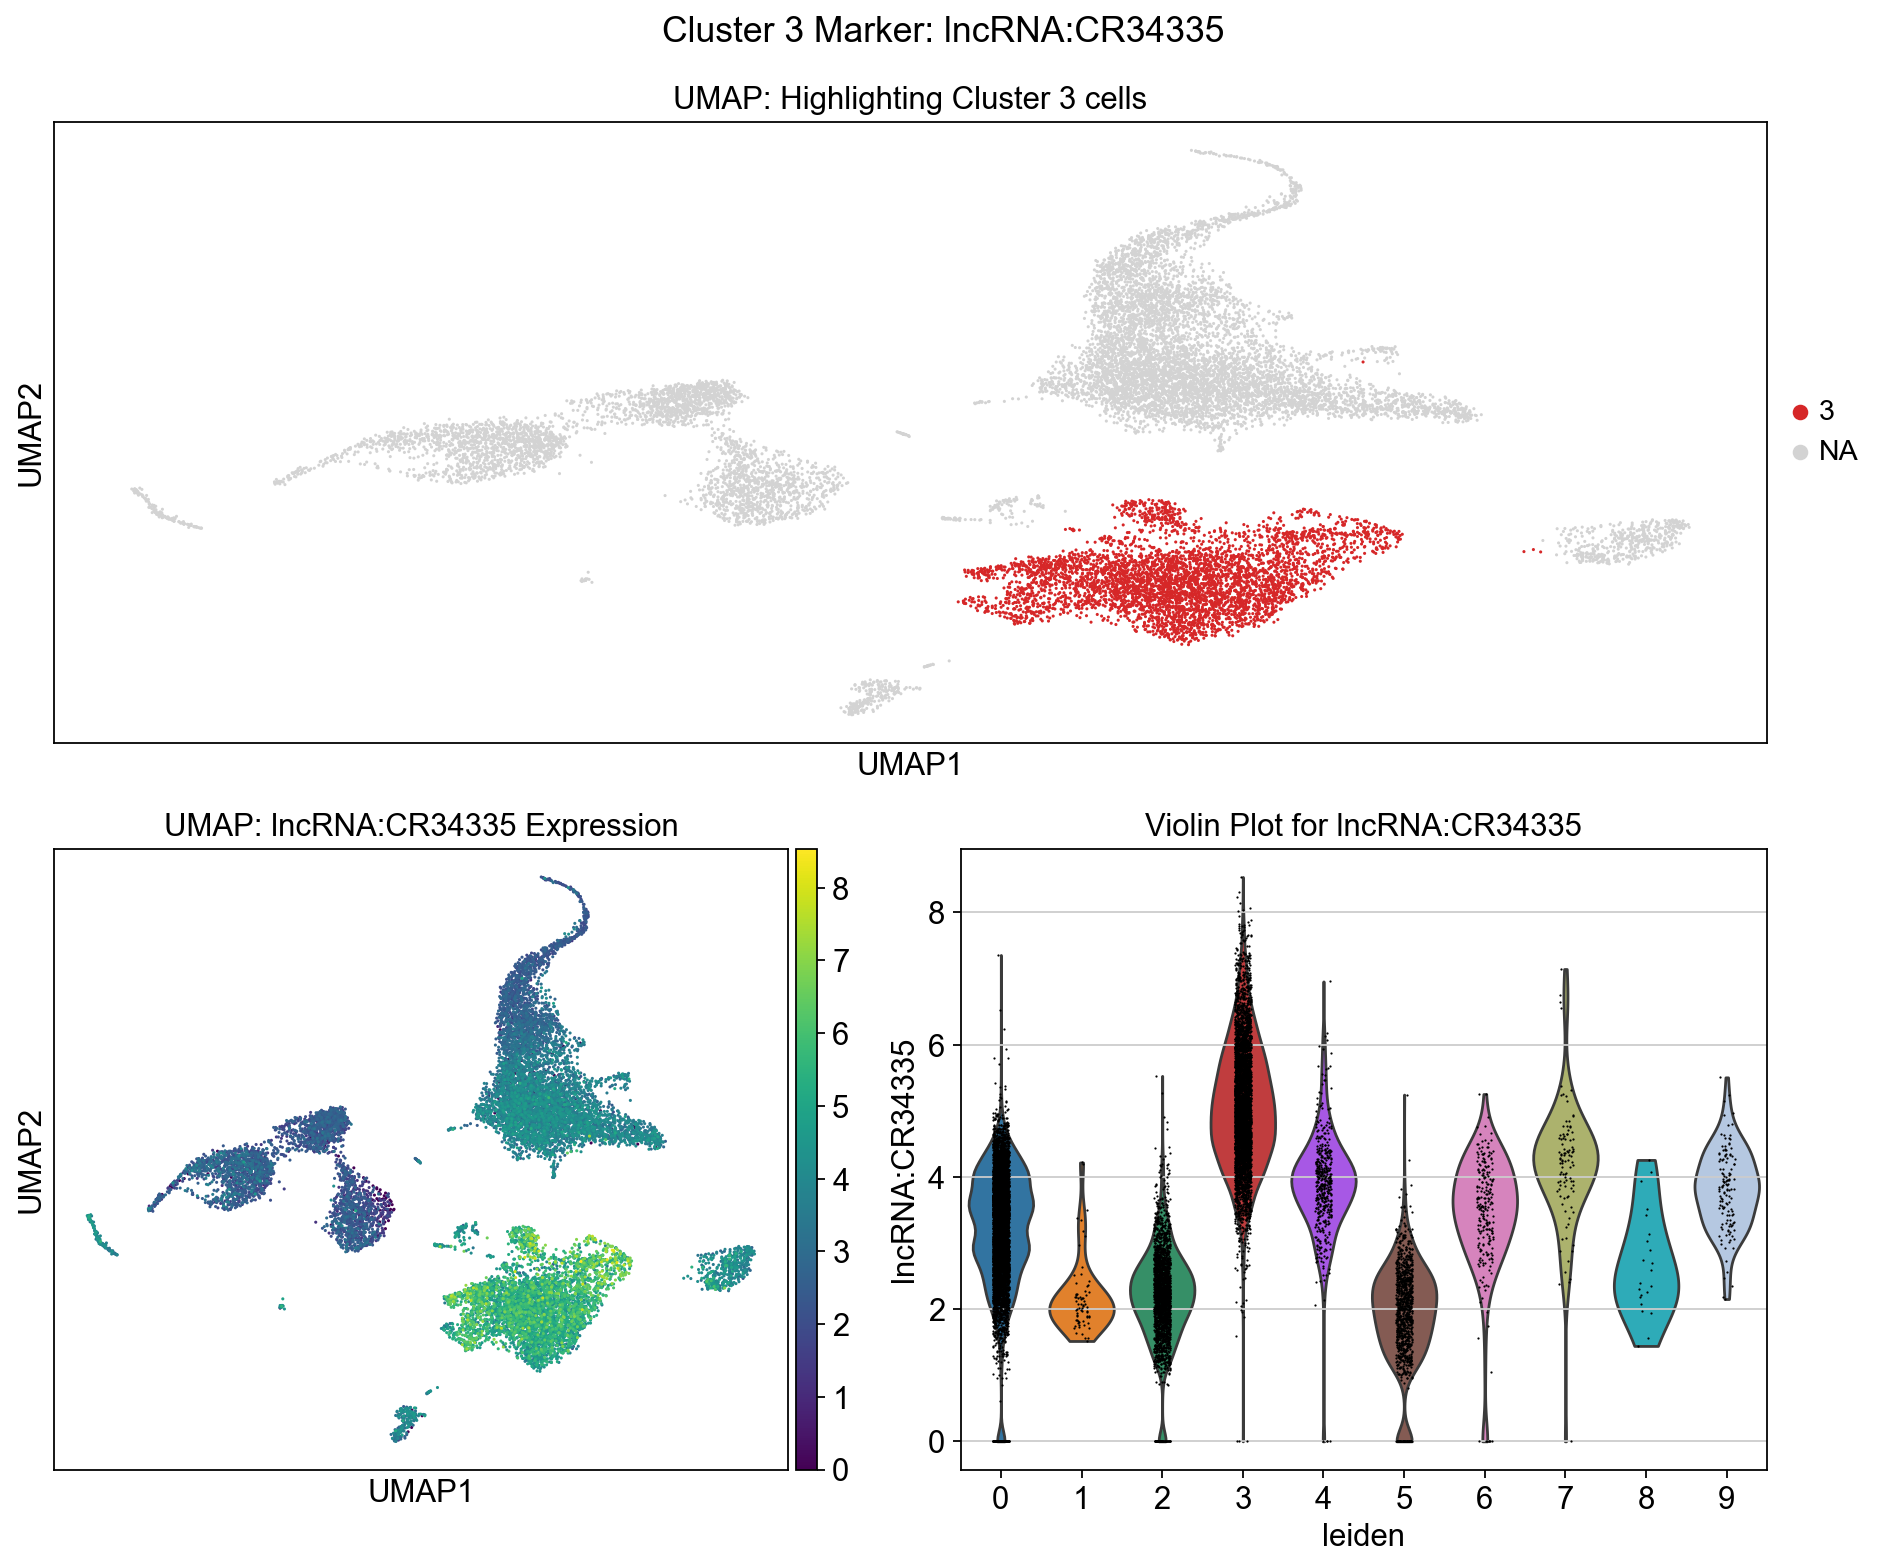

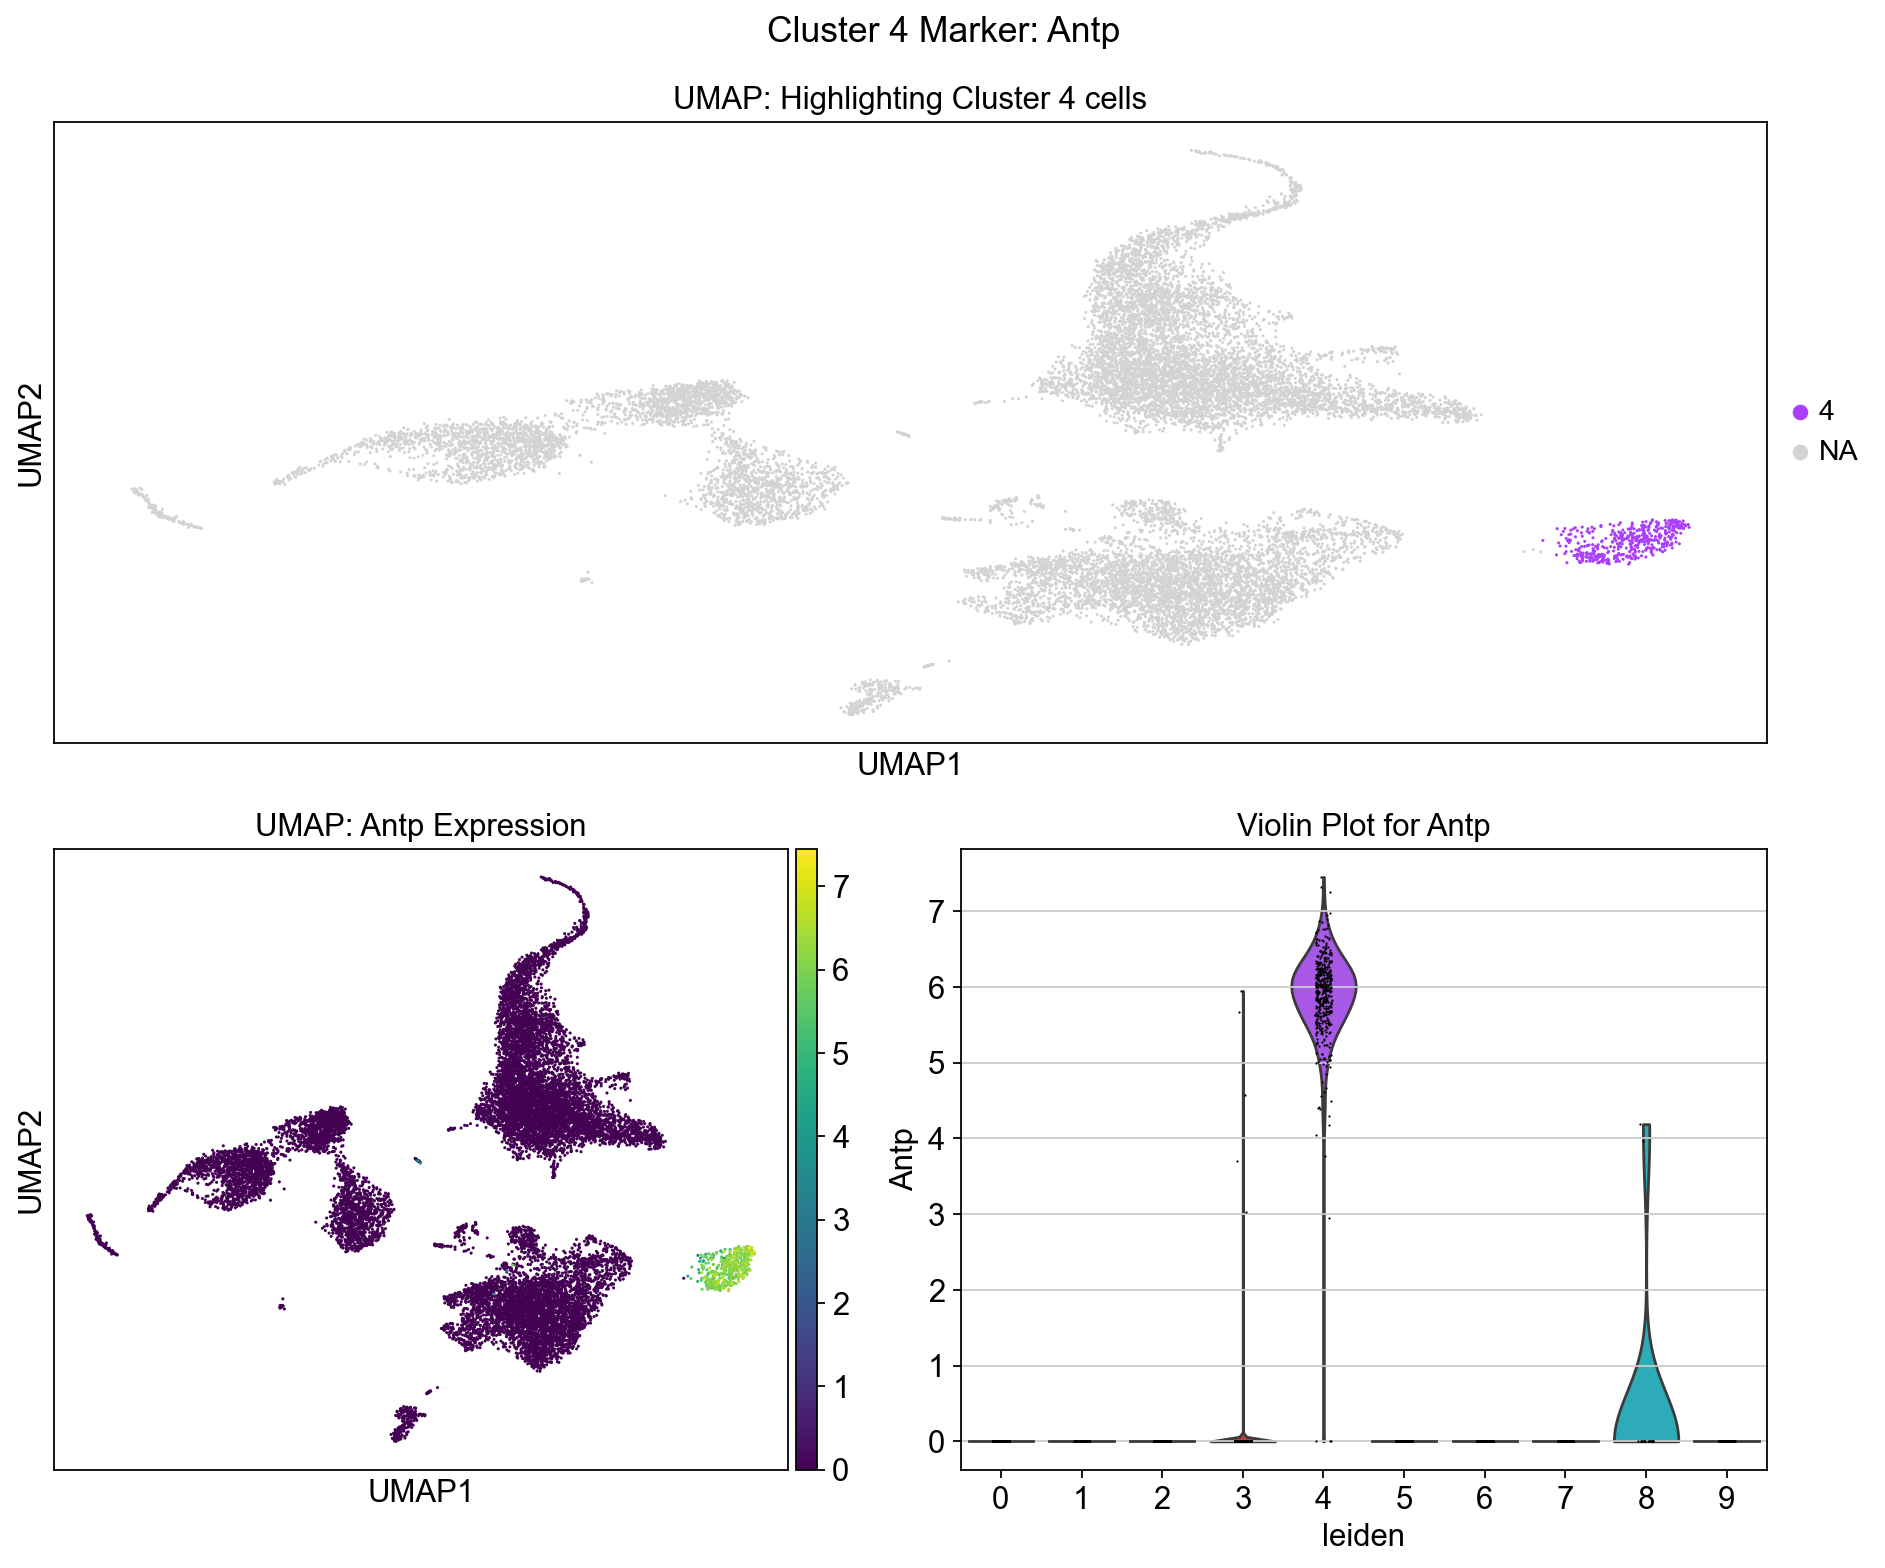

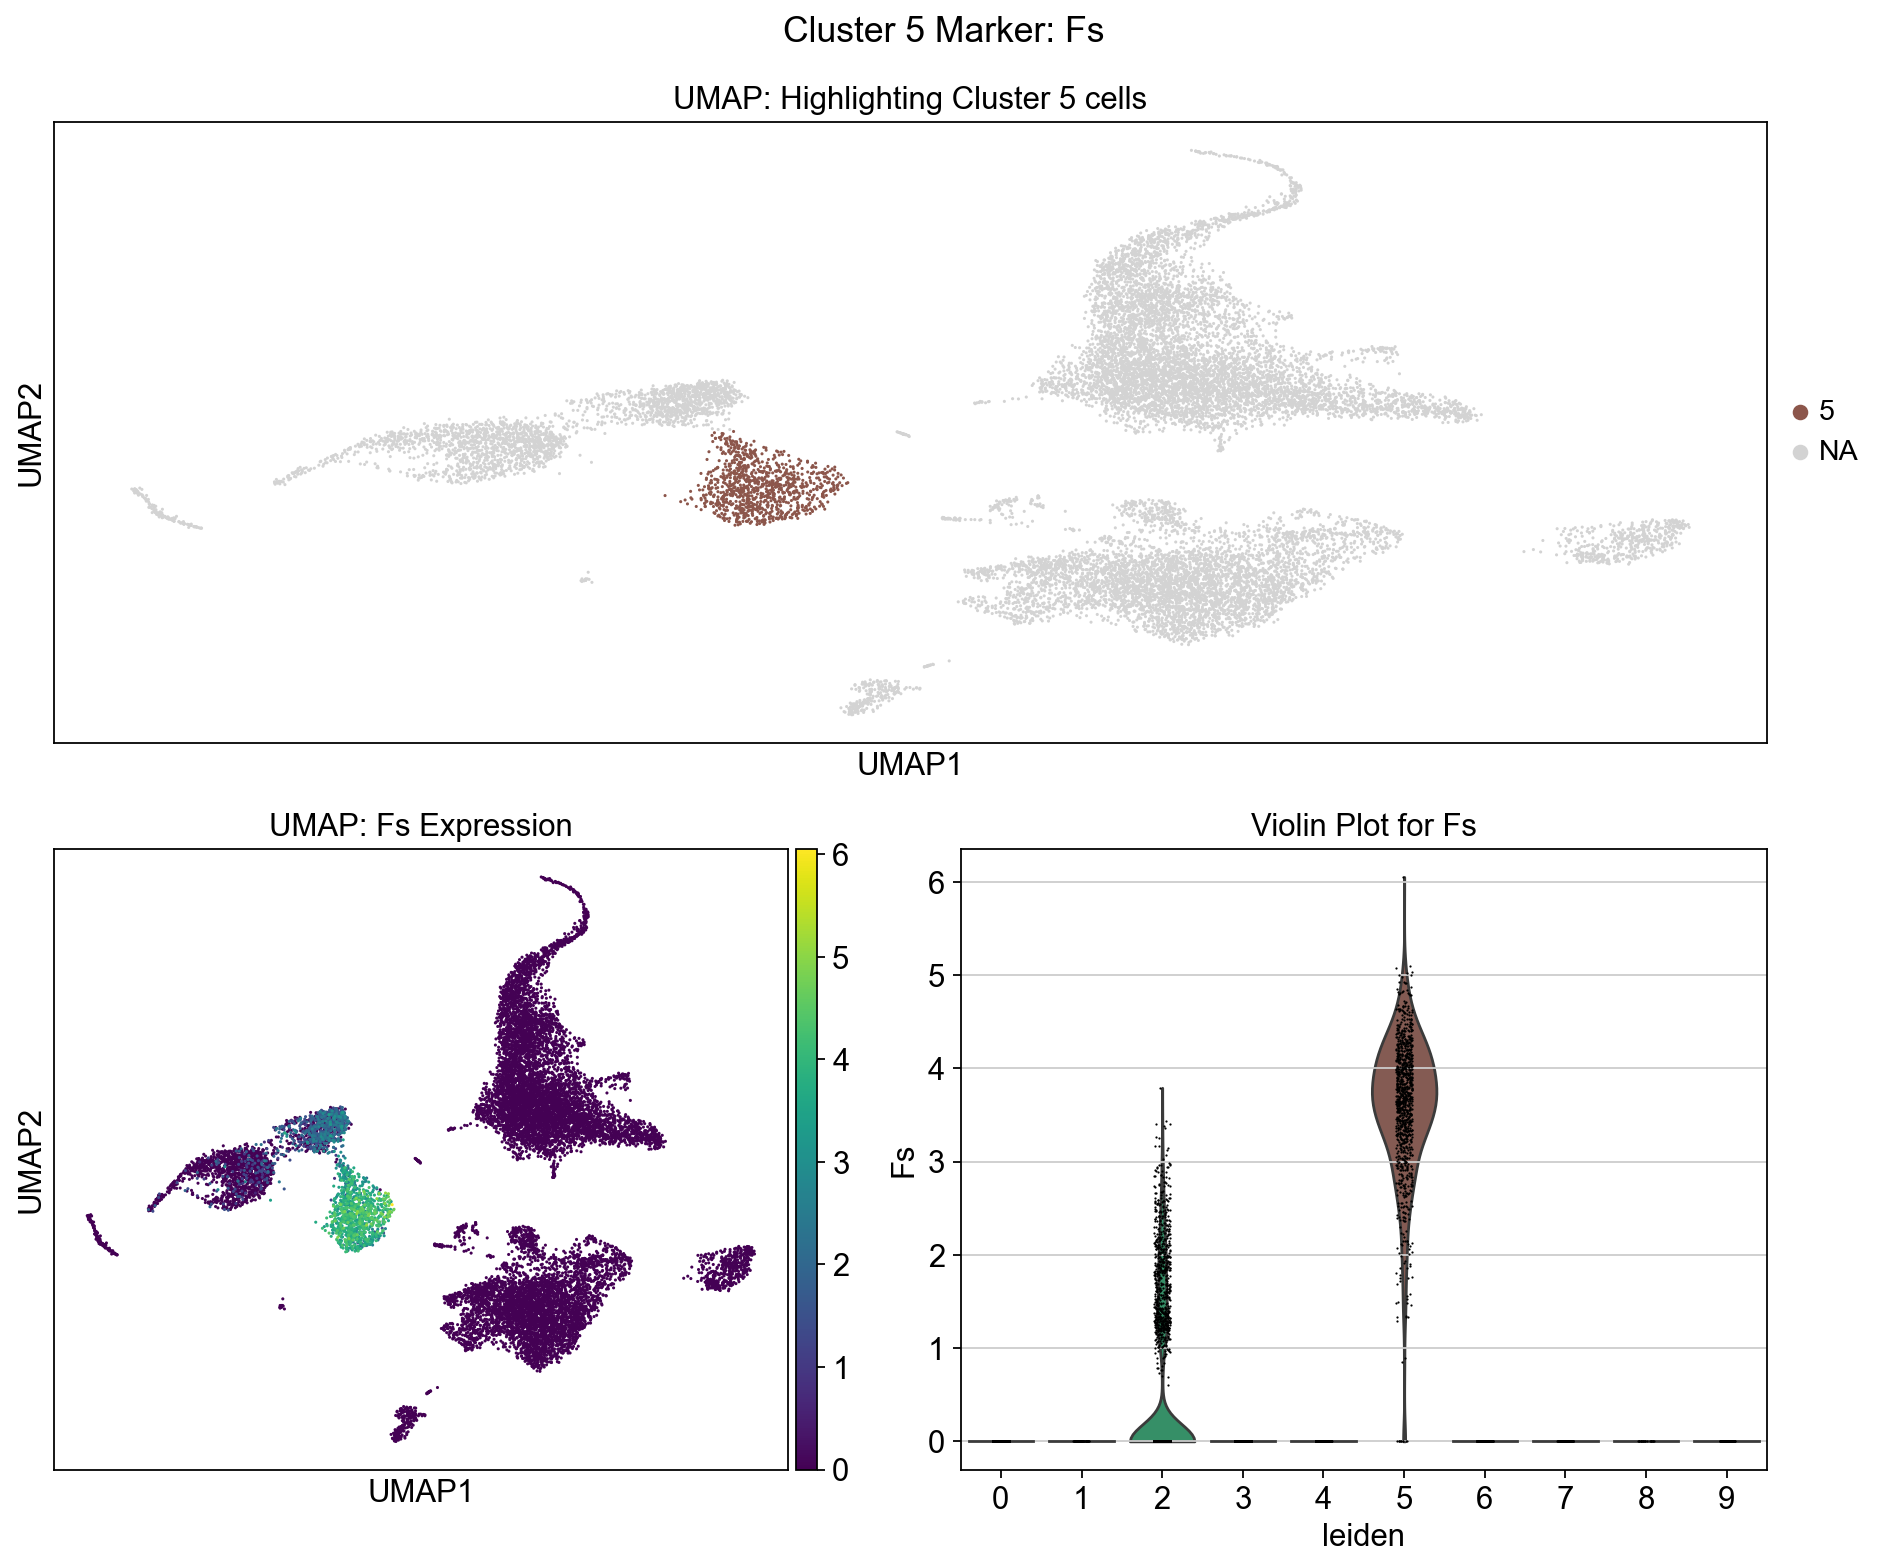

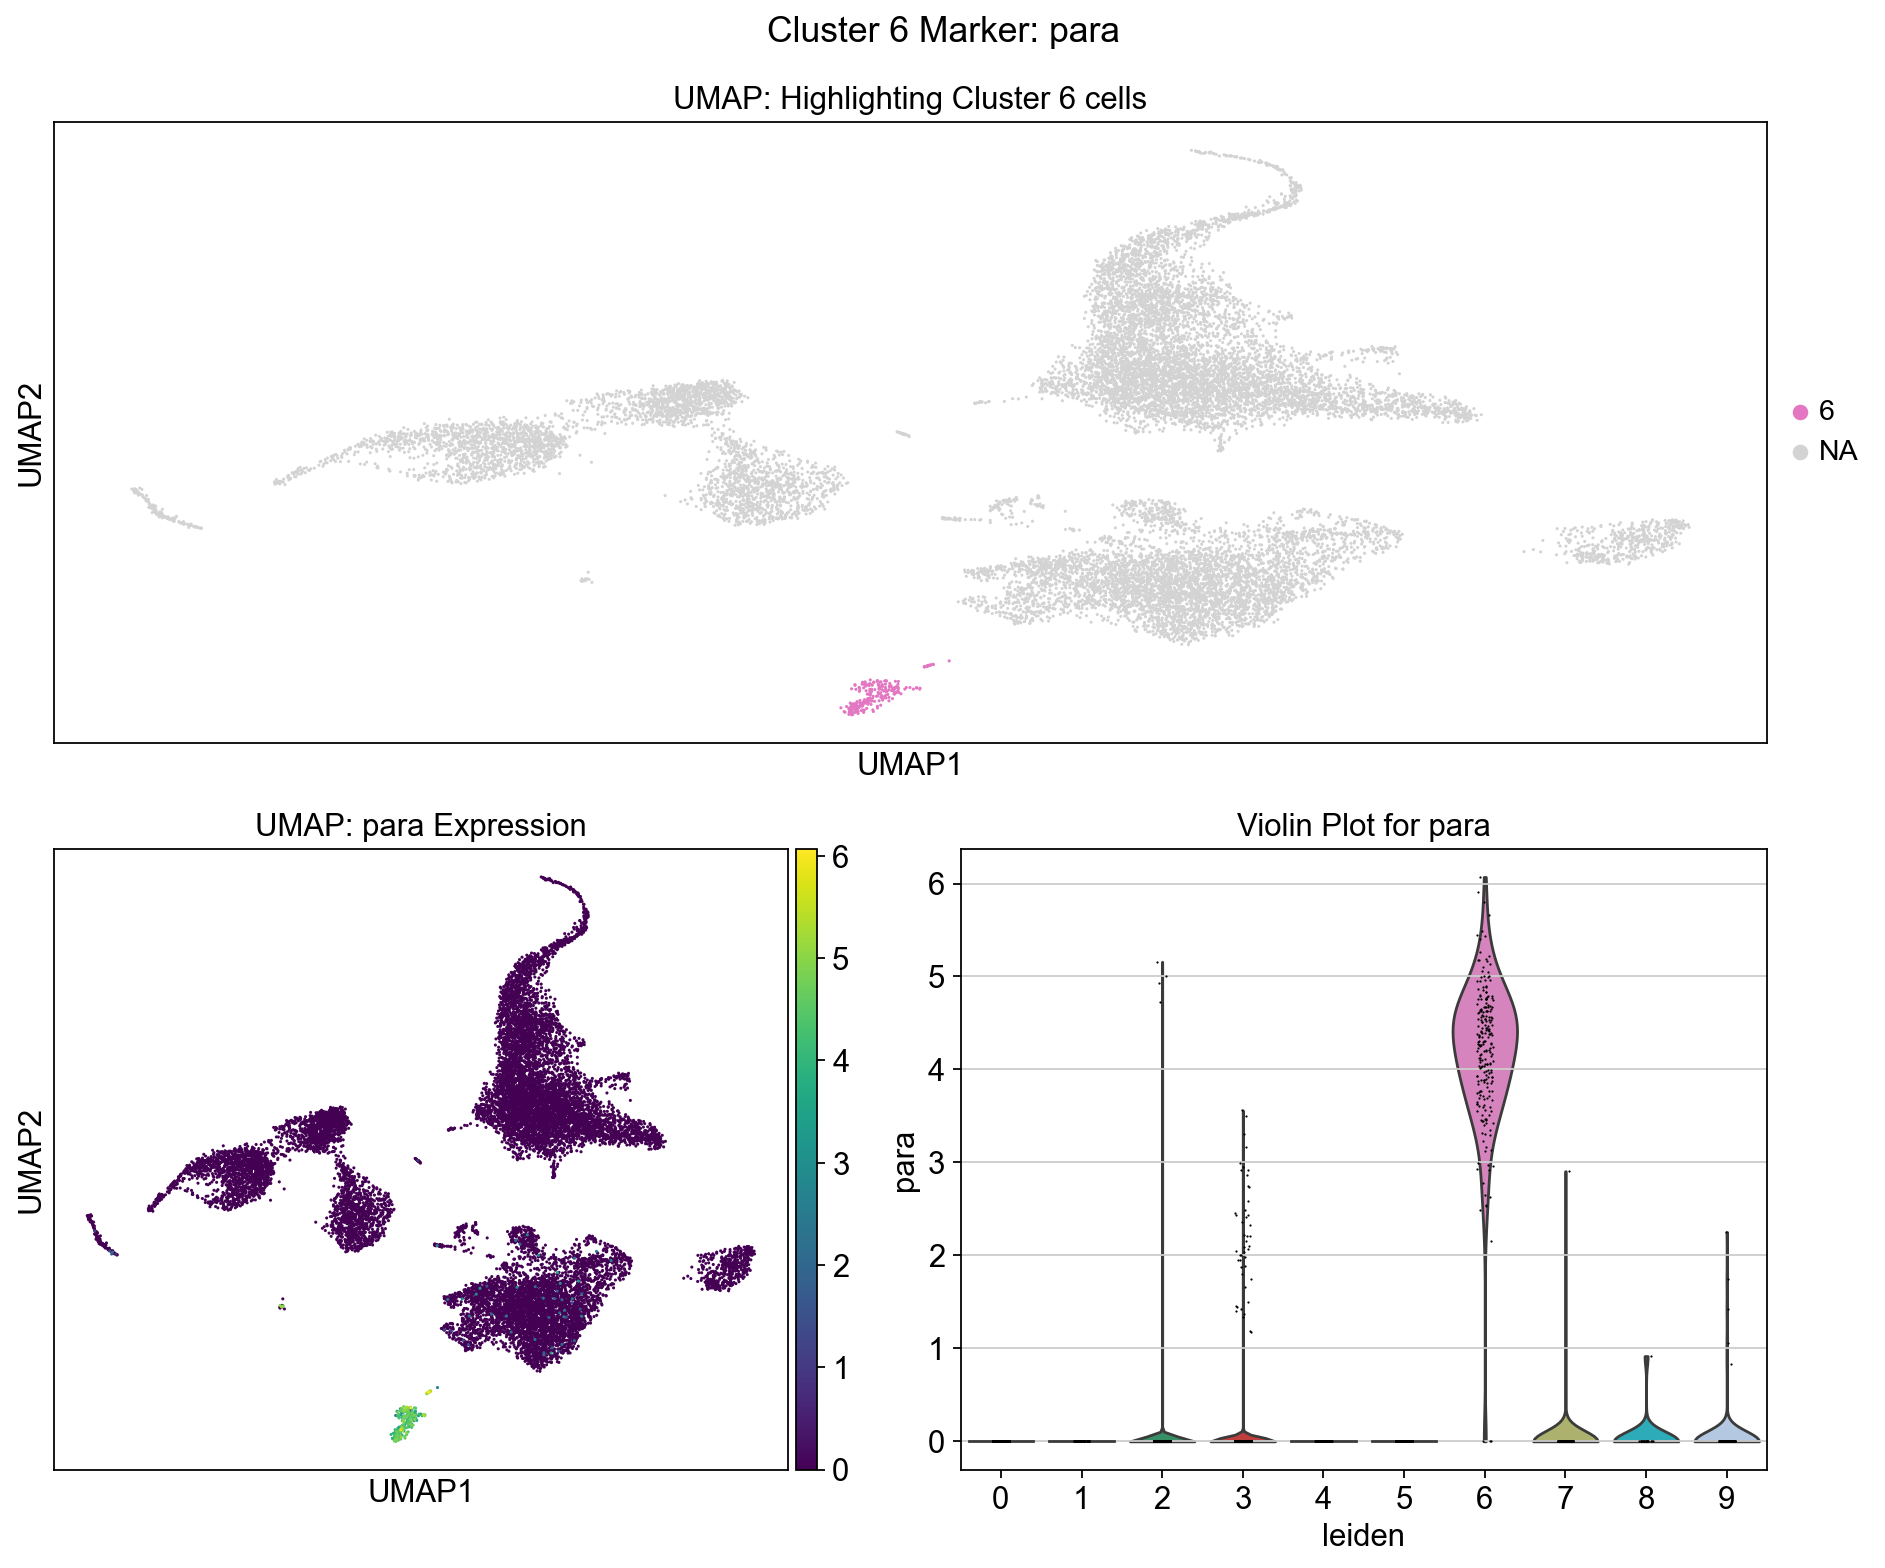

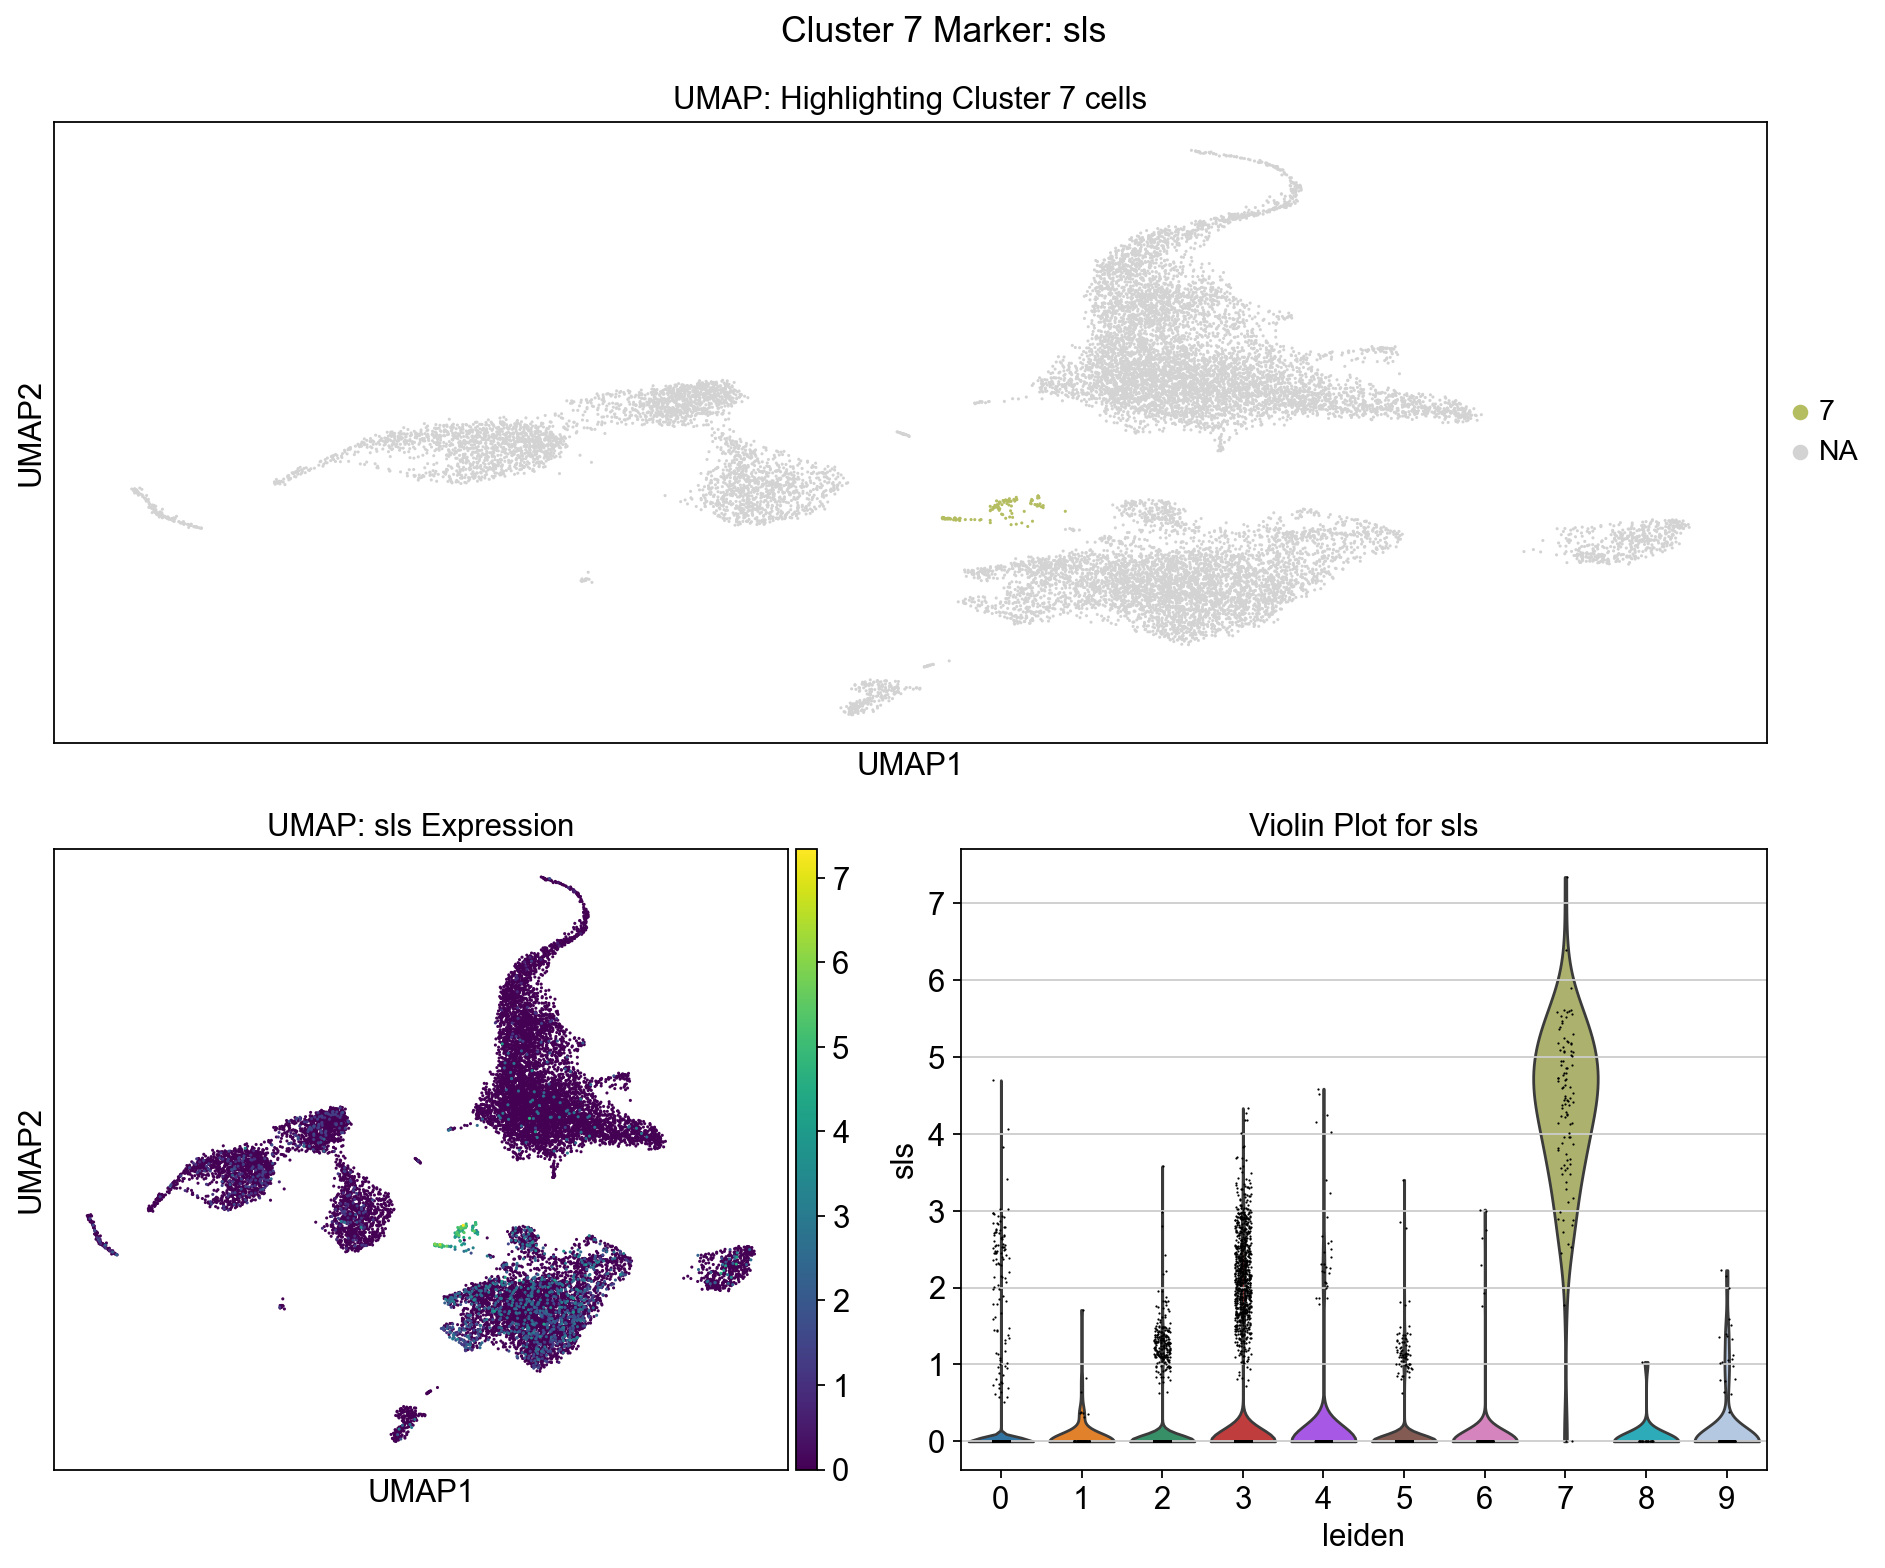

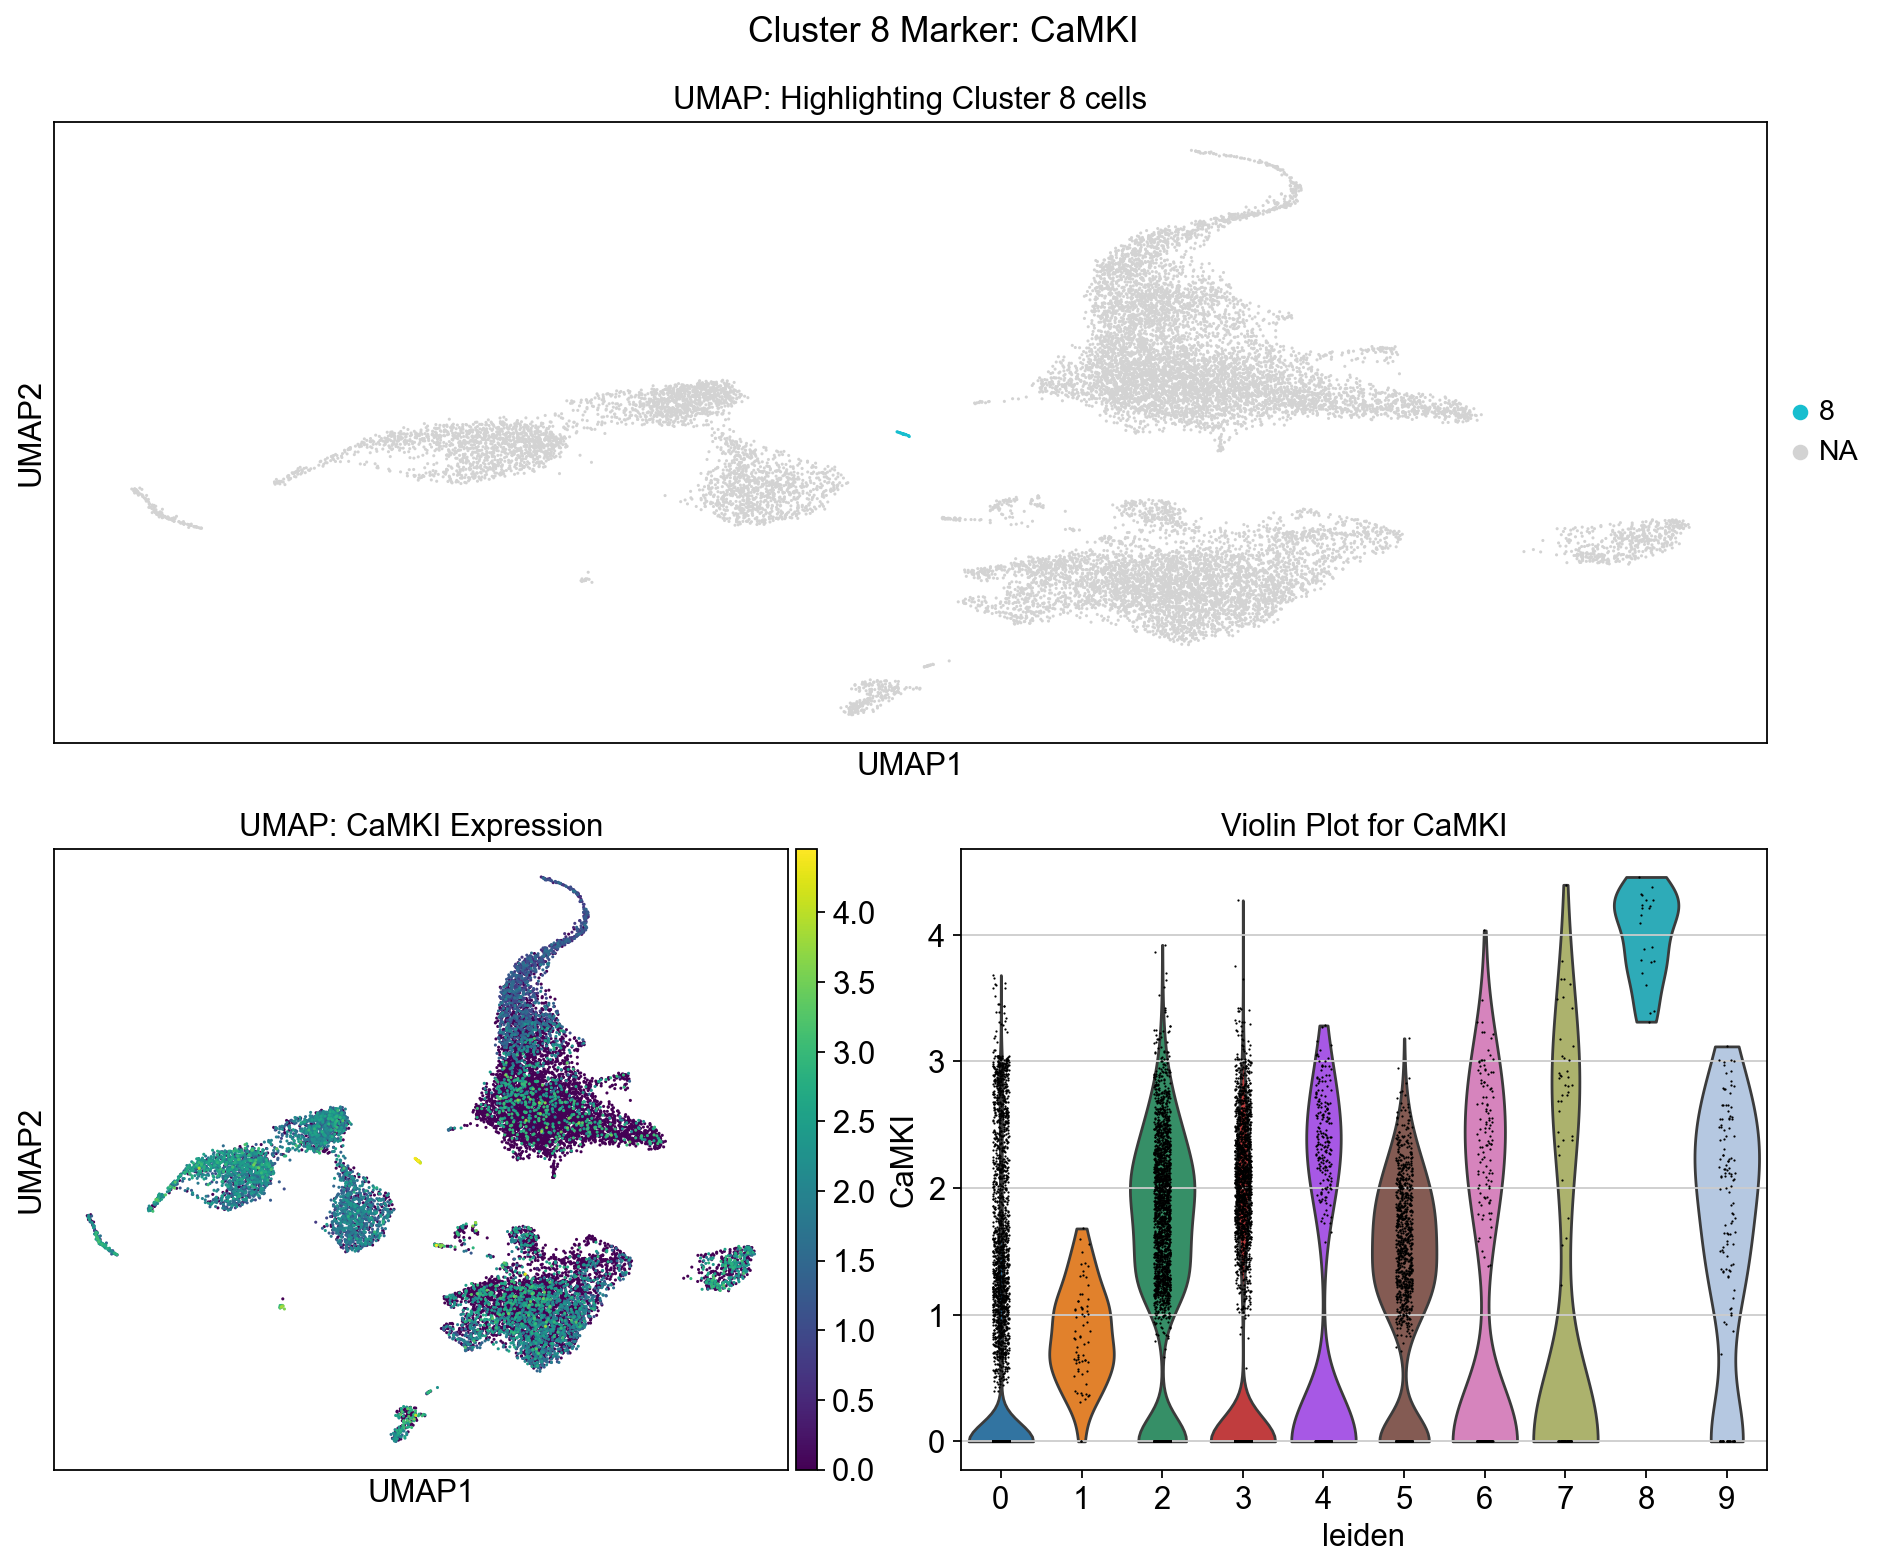

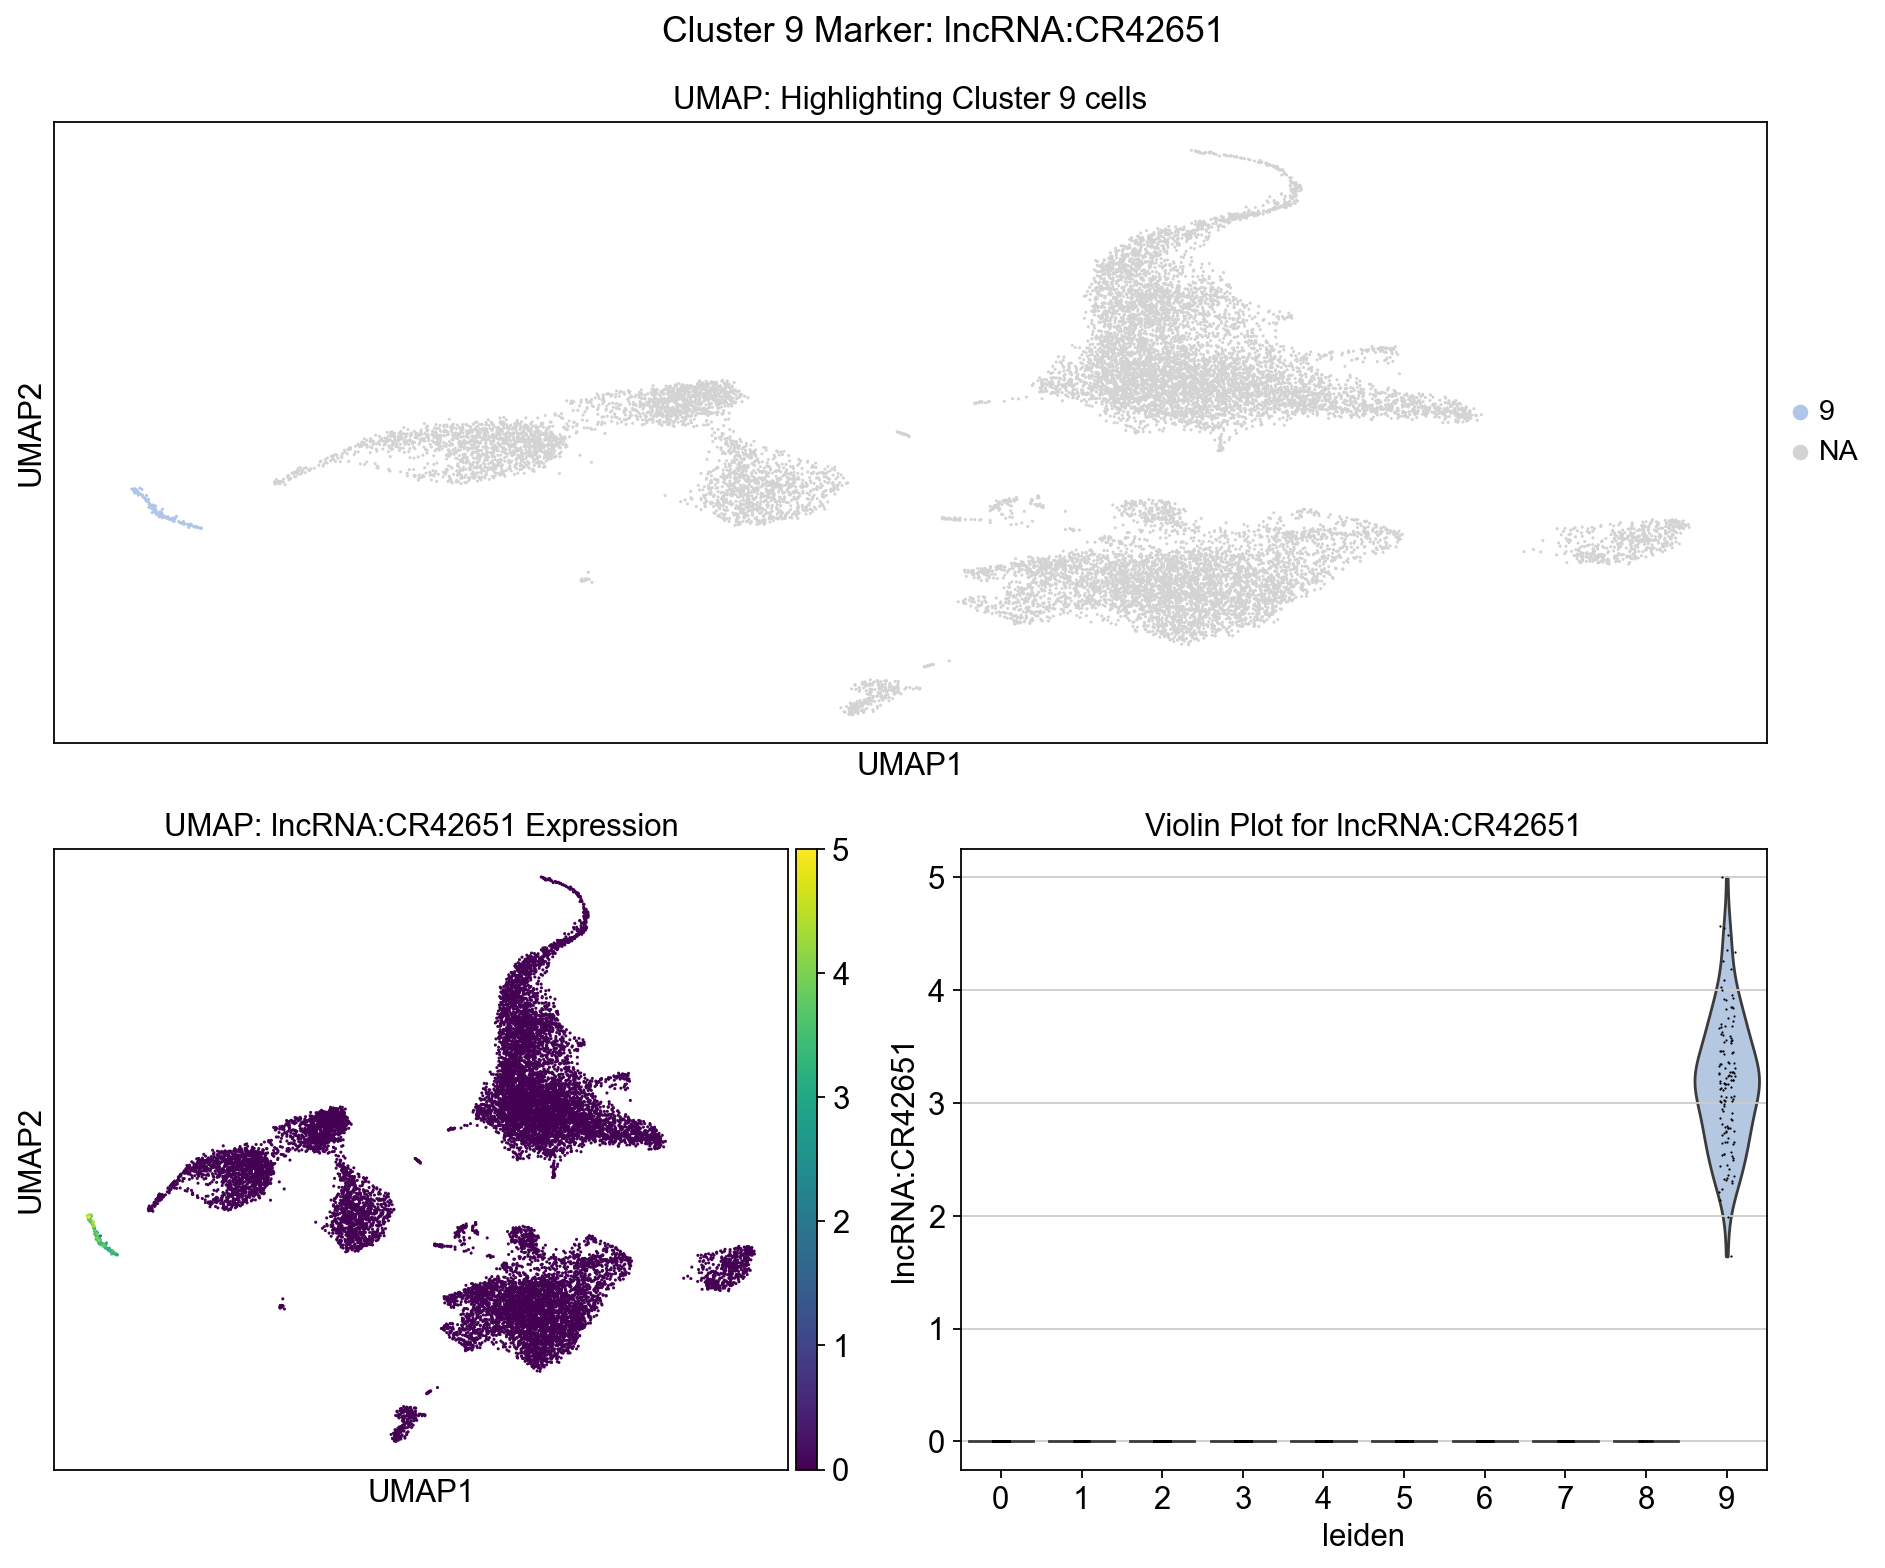

In [31]:
for i in range(len(top_candidates.keys())):
    fig = plot_cluster_marker(adata, top_candidates, i)

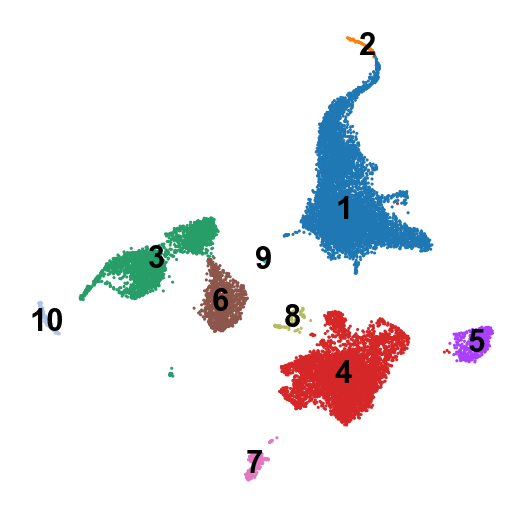

In [33]:
new_cluster_names = [
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10",
]

adata.rename_categories("leiden", new_cluster_names)

sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

1: Btl-GAL4 positive female cell, likely ovary cell

2: Btl-GAL4 positive female cell, cluster 1, likely ovary cell

3: Btl-GAL4 positive female cell, likely ovary cell, sim+

4: Adult tracheal cell

5: Adult tracheal cell; unannotated

6: Btl-GAL4 positive female cell, likely ovary cell, sim+, H15+

7: Adult neuron

8: Muscle cell

9: Unannotated

10: Adult tracheal cell; unannotated

# Conclusion

To summarize, we will briefly answer the assignment questions. In our dataset, we identified 10 clusters and 6 unique cell types (btl-GAL4 positive female cell, likely ovary cell, adult tracheal cell, adult neuron, muscle cell, eye photoreceptor cells, and adult fat body cells), plus one unannotated cluster. Each cell type was characterized by its top-ranking marker genes (shown in Step 9 above), and we verified the consistency of our results by checking the top 3 genes, as well as the top 25 and 100 genes per cluster.

Some clusters contained overlapping marker genes, suggesting that certain cell types exist in multiple states, such as different maturation stages or expression profiles. This explains why we found btl-GAL4 positive female cells and adult tracheal cells in several clusters, similar to ASAP.

Using Louvain clustering might have provided a further separation of subclusters, potentially distinguishing different cell states more effectively. However, our approach still showed the major cell types, and the results remained consistent across different gene-ranking thresholds, proving the robustness of our clustering.